# Sumário

[*Imports*](#imports)

[*Helper Functions*](#helper-functions)

[*Data*](#data)

[1. Tratamento inicial dos dados](#1-tratamento-inicial-dos-dados) 

[2. Estatística descritiva](#2-estatistica-descritiva)

[3. Feature Engineering](#3-feature-engineering)

[4. Filtragem de variáveis](#4-filtragem-de-varaveis)

[5. EDA](#5-eda)

[6. Preparação dos dados](#6-preparacao-dos-dados)

[7. Feature Selection](#7-feature-selection)

[8. Machine Learning Models](#8-machine-learning-models)

[9. Hyperparameter Fine Tuning](#9-hyperparameter-fine-tuning)

[10. Tradução e Interpretação do Erro](#10-traducao-e-interpretacao-do-erro)

[11. Deploy](#11-deploy)


OBSERVAÇÃO: Os links referenciados não funcionam se utilizados dentro da IDE do VSCode. 

# Imports

In [95]:
import math
import datetime
import inflection
import numpy as np
import pandas as pd
import seaborn as sns
from tabulate import tabulate
from IPython.display import Image
from matplotlib import pyplot as plt
from matplotlib.gridspec import GridSpec

from boruta import BorutaPy
from scipy import stats as ss
from sklearn.preprocessing import RobustScaler, MinMaxScaler, LabelEncoder
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, Lasso
import xgboost as xgb
from sklearn.model_selection import TimeSeriesSplit, cross_val_score, RandomizedSearchCV


import os
import json
import pickle
import requests
from flask import Flask, request



# Helper Functions

In [3]:

def cramer_v(x, y):
    """
    Calcula o V de Cramer, uma medida de associação entre duas variáveis categóricas.
    
    Parâmetros:
    x (pd.Series): Primeira variável categórica.
    y (pd.Series): Segunda variável categórica.

    Retorno:
    float: Valor do V de Cramer entre 0 e 1.
    """
    # Tabela de contingência
    cm = pd.crosstab(x, y).to_numpy()
    n = cm.sum()  # Total de observações
    r, k = cm.shape  # Dimensões da matriz

    # Estatística Qui-quadrado
    chi2, _, _, _ = ss.chi2_contingency(cm)
    
    # Correção do Qui-quadrado
    chi2_corr = max(0, chi2 - (k - 1) * (r - 1) / (n - 1))
    k_corr = k - (k - 1) ** 2 / (n - 1)
    r_corr = r - (r - 1) ** 2 / (n - 1)

    # Cálculo do V de Cramer
    return np.sqrt((chi2_corr / n) / min(k_corr - 1, r_corr - 1))

def ml_error(model_name, y, yhat):
    mae = mean_absolute_error(y, yhat)
    mape = mean_absolute_percentage_error(y, yhat)
    rmse = np.sqrt(mean_squared_error(y, yhat))
    
    return pd.DataFrame({'Model': model_name, 
                         'MAE': mae, 
                         'MAPE': mape,
                         'RMSE': rmse}, index=[0])

def evaluate_models(models, X, y, cv):
    results = []

    for name, model in models.items():
        mae_list, mape_list, rmse_list = [], [], []
        
        for train_idx, test_idx in cv.split(X):
            X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
            y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

            model.fit(X_train, y_train)

            y_pred = model.predict(X_test)
            
            # Reverta a transformação log antes de calcular as métricas
            y_pred = np.expm1(y_pred)
            y_test = np.expm1(y_test)
            
            # Calcular as métricas
            mae_list.append(mean_absolute_error(y_test, y_pred))
            mape_list.append(mean_absolute_percentage_error(y_test, y_pred))
            rmse_list.append(np.sqrt(mean_squared_error(y_test, y_pred)))

        # Salvar a média das métricas para o modelo
        results.append({
            'Model name': name,
            'MAE CV': f"{np.mean(mae_list):.2f} +/- {np.std(mae_list):.2f}",
            'MAPE CV': f"{np.mean(mape_list):.4f} +/- {np.std(mape_list):.4f}",
            'RMSE CV': f"{np.mean(rmse_list):.2f} +/- {np.std(rmse_list):.2f}"
        })
    
    return pd.DataFrame(results)


# Data

In [4]:
# Carregando o dataset
df_sales_raw = pd.read_csv('../data/train.csv', low_memory=False)
df_store_raw = pd.read_csv('../data/store.csv', low_memory=False)

# Juntando os dois datasets (merge)
df_raw = pd.merge(df_sales_raw, df_store_raw, how='left', on='Store')
df_raw.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,5,2015-07-31,6064,625,1,1,0,1,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,5,2015-07-31,8314,821,1,1,0,1,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,5,2015-07-31,4822,559,1,1,0,1,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


# 1. Tratamento inicial dos dados

In [5]:
df1 = df_raw.copy()

In [6]:
# Renomear colunas - formato snakecase
df1.columns = [inflection.underscore(col) for col in df1.columns]
df1.columns

Index(['store', 'day_of_week', 'date', 'sales', 'customers', 'open', 'promo',
       'state_holiday', 'school_holiday', 'store_type', 'assortment',
       'competition_distance', 'competition_open_since_month',
       'competition_open_since_year', 'promo2', 'promo2_since_week',
       'promo2_since_year', 'promo_interval'],
      dtype='object')

Vamos checar as dimensões do dataset.

In [7]:
print(f'Número de linhas: {df1.shape[0]}')
print(f'Número de colunas: {df1.shape[1]}')

Número de linhas: 1017209
Número de colunas: 18


Vamos também checar os tipos dos dados.

In [8]:
df1['date'] = pd.to_datetime(df1['date'])
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

### 1.1 Tratamento dos dados - Dados faltantes 

Vamos também analisar e tratar os dados faltantes.

In [9]:
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

In [10]:
# Tratando coluna competition_distance 
df1['competition_distance'] = df1['competition_distance'].apply(lambda x: 200000.0 if math.isnan(x) else x)

# Tratando coluna competition_open_since_month
df1['competition_open_since_month'] = df1.apply(lambda x: x["date"].month if math.isnan(x["competition_open_since_month"]) else x["competition_open_since_month"], axis = 1)

# Tratando coluna competition_open_since_year
df1['competition_open_since_year'] = df1.apply(lambda x: x["date"].year if math.isnan(x["competition_open_since_year"]) else x["competition_open_since_year"], axis = 1)

# Tratando coluna promo2_since_week
df1['promo2_since_week'] = df1.apply(lambda x: x["date"].week if math.isnan(x["promo2_since_week"]) else x["promo2_since_week"], axis = 1)

# Tratando coluna promo2_since_year 
df1['promo2_since_year'] = df1.apply(lambda x: x["date"].year if math.isnan(x["promo2_since_year"]) else x["promo2_since_year"], axis = 1)

# Tratando coluna promo_interval
month_map = {1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'}
df1.fillna({'promo_interval': 0}, inplace=True)
df1['month_map'] = df1['date'].dt.month.map(month_map)
df1['is_promo'] = df1[['promo_interval', 'month_map']].apply(lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split(',') else 0, axis=1)

In [11]:
# Checando se ainda existem valores nulos
df1.isna().sum()

store                           0
day_of_week                     0
date                            0
sales                           0
customers                       0
open                            0
promo                           0
state_holiday                   0
school_holiday                  0
store_type                      0
assortment                      0
competition_distance            0
competition_open_since_month    0
competition_open_since_year     0
promo2                          0
promo2_since_week               0
promo2_since_year               0
promo_interval                  0
month_map                       0
is_promo                        0
dtype: int64

### 1.2 Tratamento dos dados - Data types

In [12]:
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype(int)
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype(int)
df1['promo2_since_week'] = df1['promo2_since_week'].astype(int)
df1['promo2_since_year'] = df1['promo2_since_year'].astype(int)

# 2 .Estatística Descritiva 

In [13]:
# Separando as colunas categóricas e numéricas
num_attributes = df1.select_dtypes(include=['int64', 'float64'])
cat_attributes = df1.select_dtypes(exclude=['int64','float64','datetime'])

### 2.1 Dados numéricos

In [14]:
# Calculando as medidas de tendência central e de dispersão
m = num_attributes.agg(['min', 'max', 'mean', 'median', 'std', lambda x: x.max()-x.min(), 'skew', 'kurtosis']).T

# Renomeando as colunas
m.columns = ['min', 'max', 'mean', 'median', 'std', 'range', 'skew', 'kurtosis']

# Resetando o índice para transformar os atributos em uma coluna
m = m.reset_index().rename(columns={'index': 'attributes'})

m

,attributes,min,max,mean,median,std,range,skew,kurtosis
0,store,1.0,1115.0,558.429727,558.0,321.908651,1114.0,-0.000955,-1.200524
1,day_of_week,1.0,7.0,3.998341,4.0,1.997391,6.0,0.001593,-1.246873
2,sales,0.0,41551.0,5773.818972,5744.0,3849.926175,41551.0,0.641460,1.778375
3,customers,0.0,7388.0,633.145946,609.0,464.411734,7388.0,1.598650,7.091773
4,open,0.0,1.0,0.830107,1.0,0.375539,1.0,-1.758045,1.090723
5,promo,0.0,1.0,0.381515,0.0,0.485759,1.0,0.487838,-1.762018
6,school_holiday,0.0,1.0,0.178647,0.0,0.383056,1.0,1.677842,0.815154
7,competition_distance,20.0,200000.0,5935.442677,2330.0,12547.652996,199980.0,10.242344,147.789712
8,competition_open_since_month,1.0,12.0,6.786849,7.0,3.311087,11.0,-0.042076,-1.232607
9,competition_open_since_year,1900.0,2015.0,2010.324840,2012.0,5.515593,115.0,-7.235657,124.071304


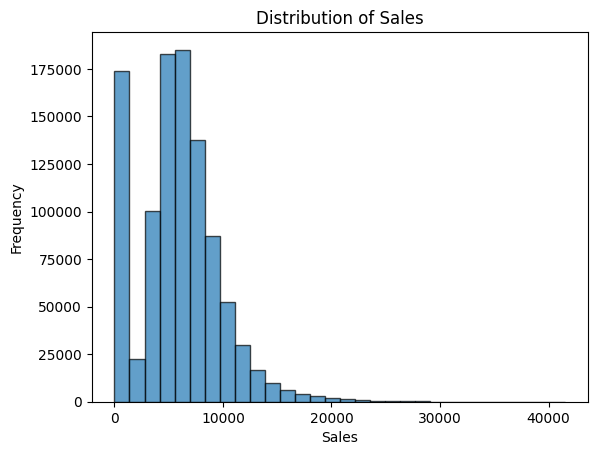

In [15]:
plt.hist(df1['sales'], bins=30, edgecolor='black', alpha=0.7)
plt.xlabel('Sales')
plt.ylabel('Frequency')
plt.title('Distribution of Sales')
plt.show()

### 2.2 Dados categóricos

In [16]:
cat_attributes.apply(lambda x: x.unique().shape[0])

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

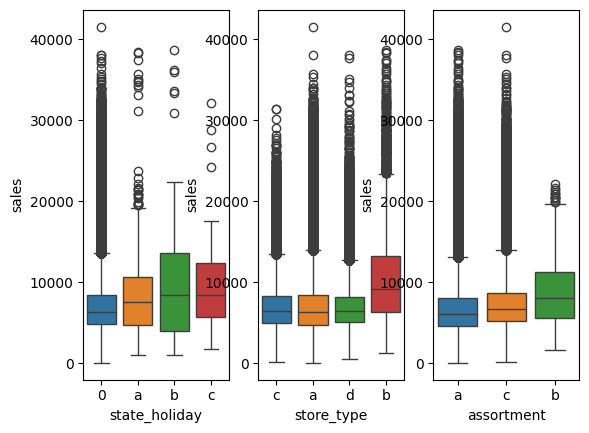

In [17]:
aux1 = df1[(df1['state_holiday'] != 0) &(df1['sales'] > 0)]
plt.subplot(1,3,1)
sns.boxplot(x='state_holiday', y='sales', data=aux1, hue='state_holiday')
plt.subplot(1,3,2)
sns.boxplot(x='store_type', y='sales', data=aux1, hue='store_type')
plt.subplot(1,3,3)
sns.boxplot(x='assortment', y='sales', data=aux1, hue='assortment');

# 3. Feature Engineering 

In [18]:
df2 = df1.copy()

### 3.1 Hipóteses

#### 3.1.1 Mapa mental de hipóteses

Vamos utilizar um mapa de hipóteses para nos orinetar no desenvolvimento das features.

In [19]:
Image('img/MindMapHypothesis.png')

FileNotFoundError: No such file or directory: 'img/MindMapHypothesis.png'

FileNotFoundError: No such file or directory: 'img/MindMapHypothesis.png'

<IPython.core.display.Image object>

#### 3.1.2 Criação de hipóteses

**LOJAS**

- Lojas com *maior número de funcionários* deveriam *vender mais*.

- Lojas com *maior estoque* deveriam *vender mais*.

- Lojas com *maior porte* deveriam *vender mais*.

- Lojas com *menor porte* deveriam *vender menos*.

- Lojas com *maior sortimento* deveriam *vender mais*.

- Lojas com *competidores mais próximos* deveriam *vender menos*.

- Lojas com *competidores à mais tempo* deveriam *vendem mais*.

**PRODUTOS**

- Lojas que *investem mais em marketing* deveriam *vender mais*.

- Lojas com *maior exposição de produtos* deveriam *vender mais*.

- Lojas com *produtos com preço menor* deveriam *vender mais*.

- Lojas com *promoções mais agressivas* (descontos maiores) deveriam *vender mais*.

- Lojas com *promoções ativas por mais tempo* deveriam *vender mais*.

- Lojas com *mais dias de promoção* deveriam *vender mais*.

- Lojas com *mais promoções consecutivas* deveriam *vender mais*.

**TEMPO**

- Lojas *abertas durante o feriado de Natal* deveriam *vender mais*.

- Lojas deveriam *vender mais* ao *longo dos anos*.

- Lojas deveriam *vender mais* no *segundo semestre* do ano.

- Lojas deveriam *vender mais* depois do *dia 10* de cada mês.

- Lojas deveriam *vender menos* aos *finais de semana*.

- Lojas deveriam *vender menos* durante os *feriados escolares*.

#### 3.1.3 Lista final de hipóteses

A lista final foi obtida considerando as hipóteses que conseguiríamos validar com os dados que temos disponíveis.

- Lojas com *maior sortimento* deveriam *vender mais*.

- Lojas com *competidores mais próximos* deveriam *vender menos*.

- Lojas com *competidores à mais tempo* deveriam *vender mais*.

- Lojas com *promoções ativas por mais tempo* deveriam *vender mais*.

- Lojas com *mais dias de promoção* deveriam *vender mais*.

- Lojas com *mais promoções consecutivas* deveriam *vender mais*.

- Lojas *abertas durante o feriado de Natal* deveriam *vender mais*.

- Lojas deveriam *vender mais* ao *longo dos anos*.

- Lojas deveriam *vender mais* no *segundo semestre* do ano.

- Lojas deveriam *vender mais* depois do *dia 10* de cada mês.

- Lojas deveriam *vender menos* aos *finais de semana*.

- Lojas deveriam *vender menos* durante os *feriados escolares*.

### 3.2 Feature Engineering

In [20]:
# Extraindo o ano da data
df2['year'] = df2['date'].dt.year
# Extraindo o mês da data
df2['month'] = df2['date'].dt.month
# Extraindo o dia da data
df2['day'] = df2['date'].dt.day
# Extraindo s semana do ano da data
df2['week_of_year'] = df2['date'].dt.isocalendar().week
# Year week
df2['year_week'] = df2['date'].dt.strftime('%Y-%W')

# Tempo em meses em que há lojas concorrentes 
df2['competition_since'] = df2.apply(lambda x: datetime.datetime(year=x['competition_open_since_year'], month=x['competition_open_since_month'], day=1), axis=1)
df2['competition_time_month'] = ((df2['date'] - df2['competition_since'])/30).apply(lambda x: x.days).astype(int)

# Obter o tempo de promoção
df2['promo_since'] = pd.to_datetime(df2['promo2_since_year'].astype(str) + df2['promo2_since_week'].astype(str) + '-1', format='%Y%W-%w') - pd.Timedelta(days=7)
df2['promo_time_week'] = ((df2['date'] - df2['promo_since']).dt.days // 7).astype(int)

# Renomeando as categorias das lojas a partir da variedade de produtos
df2['assortment'] = df2['assortment'].map({'a': 'basic', 'b': 'extra', 'c': 'extended'})

# Renomeando os feriados
mapping = {'a': 'public_holiday', 'b': 'easter_holiday', 'c': 'christmas'}
df2['state_holiday'] = df2['state_holiday'].map(mapping).fillna('regular_day')


In [21]:
df2['state_holiday'].value_counts()

state_holiday
regular_day       986159
public_holiday     20260
easter_holiday      6690
christmas           4100
Name: count, dtype: int64

# 4. Filtragem de variáveis

In [22]:
df3 = df2.copy()

**FILTRAGEM DAS LINHAS**

In [23]:
df3 = df3[(df3['open']!=0) & (df3['sales']> 0)]

**FILTRAGEM DAS COLUNAS**

In [24]:
cols_drop = ['customers', 'open', 'promo_interval', 'month_map']
df3 = df3.drop(cols_drop, axis = 1)

# 5. EDA

In [25]:
df4 = df3.copy()

### 5.1 Análise Univariada

**VARIÁVEL RESPOSTA**

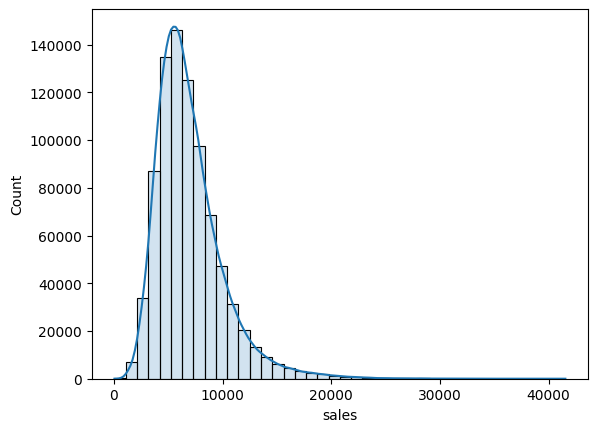

In [26]:
# Analise da variavel resposta
sns.histplot(df4['sales'], bins=40, kde=True, alpha=0.2);

**VARIÁVEIS NUMÉRICAS**

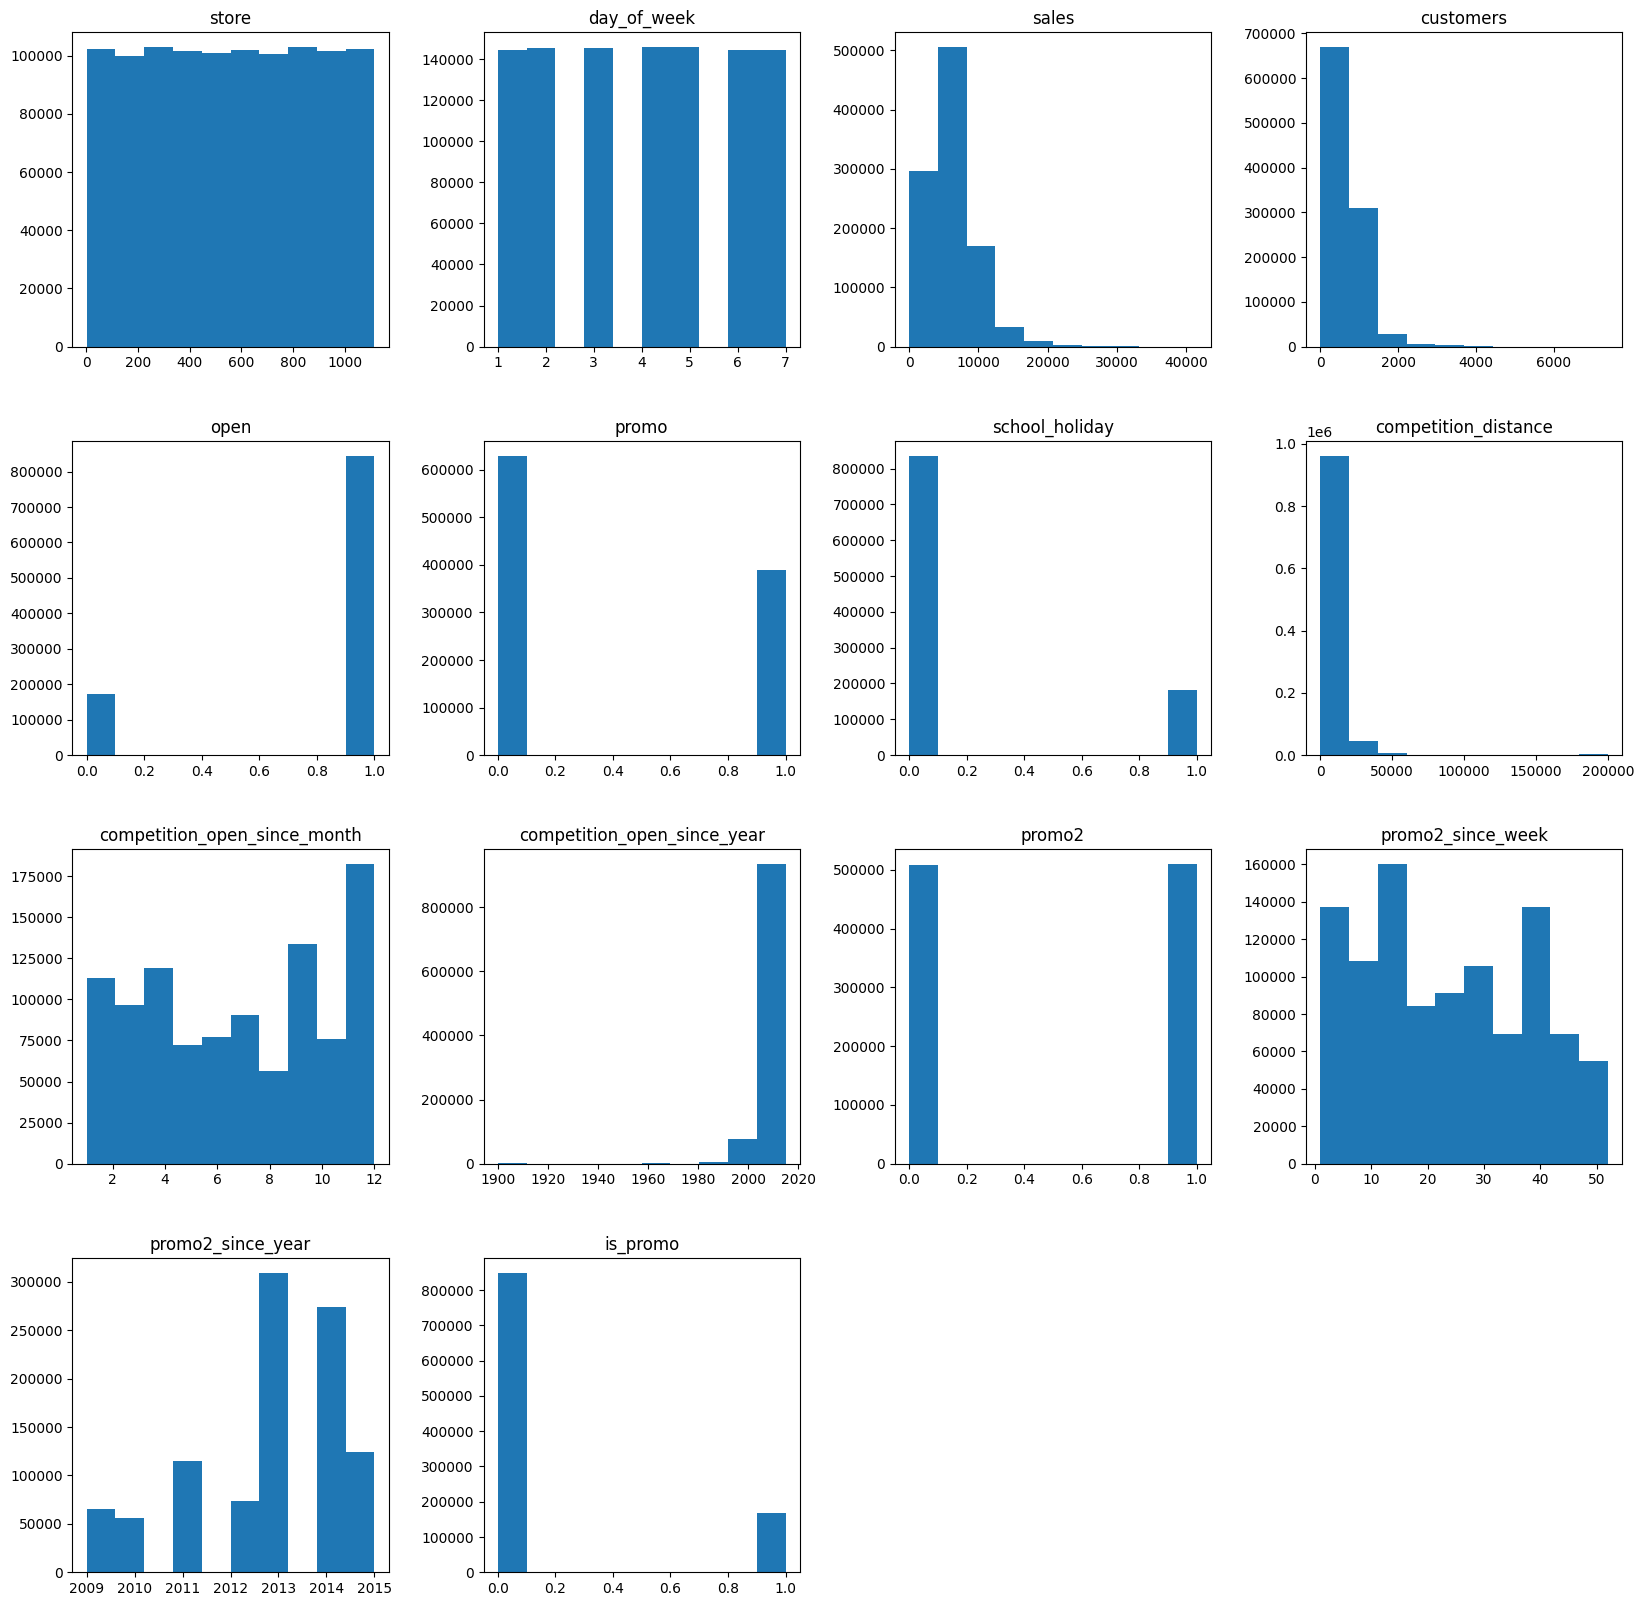

In [27]:
# Analise das variaveis numericas
num_attributes.hist(figsize=(20,20), grid=False);

**VARIÁVEIS CATEGÓRICAS**

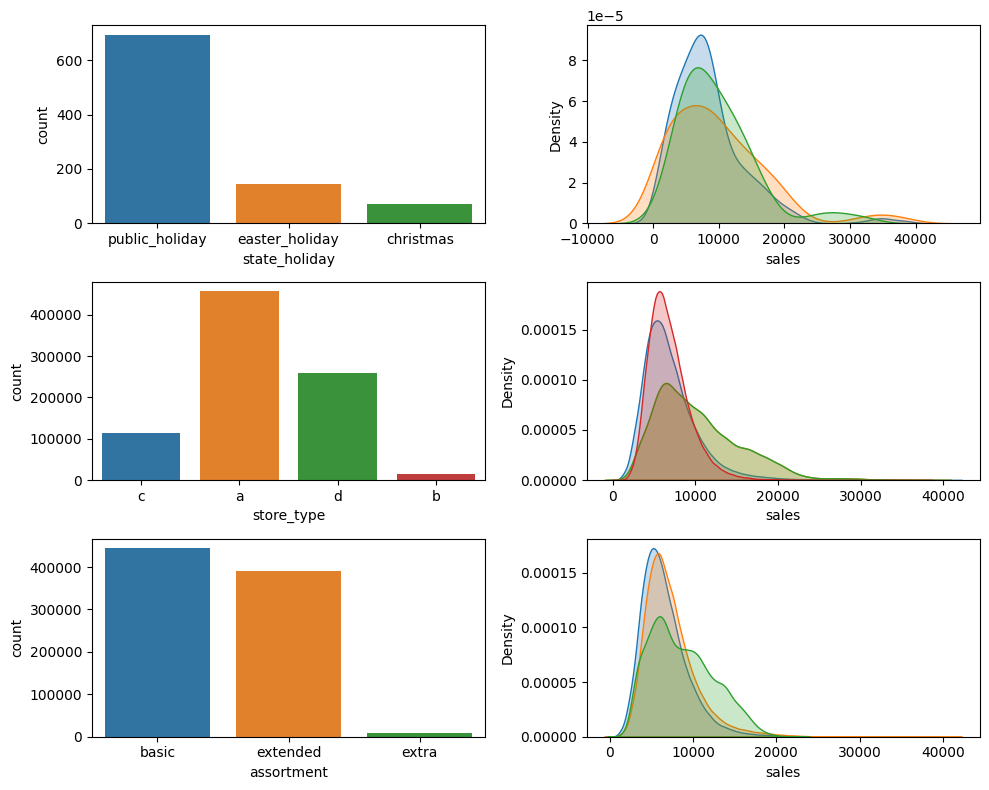

In [28]:
plt.figure(figsize=(10, 8))

# Variavel state_holiday
df4['state_holiday'].drop_duplicates()
plt.subplot(3,2,1);
aux1 = df4[df4['state_holiday'] != 'regular_day']
sns.countplot(aux1,x=aux1['state_holiday'], hue=aux1['state_holiday']);


plt.subplot(3,2,2);
sns.kdeplot(df4[df4['state_holiday'] == 'public_holiday']['sales'], label = 'public_holiday', fill = True);
sns.kdeplot(df4[df4['state_holiday'] == 'easter_holiday']['sales'], label = 'easter_holiday', fill = True);
sns.kdeplot(df4[df4['state_holiday'] == 'christmas']['sales'], label = 'christmas', fill = True);

# Variavel store_type
plt.subplot(3,2,3)
sns.countplot(df4, x=df4['store_type'], hue=df4['store_type']);

plt.subplot(3,2,4);
sns.kdeplot(df4[df4['store_type'] == 'a']['sales'], label = 'a', fill = True);
sns.kdeplot(df4[df4['store_type'] == 'b']['sales'], label = 'b', fill = True);
sns.kdeplot(df4[df4['store_type'] == 'b']['sales'], label = 'b', fill = True);
sns.kdeplot(df4[df4['store_type'] == 'd']['sales'], label = 'd', fill = True);

# Variavel assortment
plt.subplot(3,2,5);
sns.countplot(df4, x=df4['assortment'], hue=df4['assortment']); 

plt.subplot(3,2,6);
sns.kdeplot(df4[df4['assortment'] == 'basic']['sales'], label = 'basic', fill = True);
sns.kdeplot(df4[df4['assortment'] == 'extended']['sales'], label = 'extended', fill = True);
sns.kdeplot(df4[df4['assortment'] == 'extra']['sales'], label = 'extra', fill=True);
plt.tight_layout();


### 5.2 Análise Bivariada

Vamos testar algumas das hipóteses formuladas.

 **HIPÓTESE 1**

*Lojas com maior sortimento deveriam vender mais.*

Os gráficos abaixos exibem a contagem de vendas por tipo de sortimento e por semana e é possível notar que lojas na categoria 'extra' (com maior sortimento) vendem menos que as demais. Portanto, essa hipótese é <font color="Red">**FALSA**</font>.

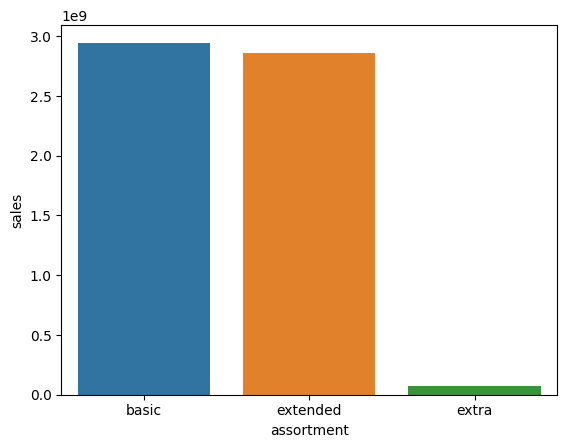

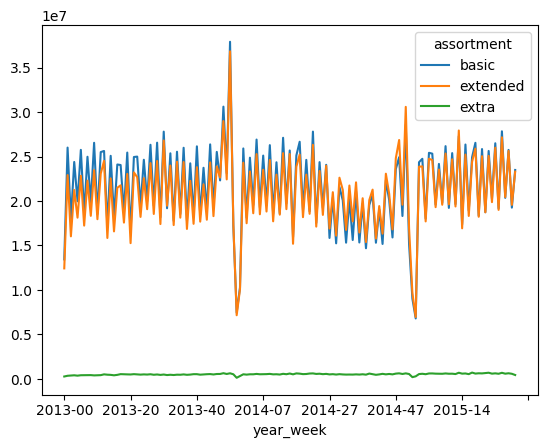

In [29]:
aux1 = df4[['assortment', 'sales']].groupby('assortment').sum().reset_index()
sns.barplot(x='assortment', y='sales', data=aux1, hue='assortment');

aux2 = df4[['year_week','assortment', 'sales']].groupby(['year_week', 'assortment']).sum().reset_index()
aux2.pivot(index='year_week', columns='assortment', values='sales').plot();

**HIPÓTESE 2**

*Lojas com competidores mais próximos deveriam vender menos.*

Os gráficos abaixos exibem a relação entre distância dos competidores mais próximos e as vendas, sendo possível notar que lojas com competidores mais próximos vendem mais. Portanto, essa hipótese é <font color="Red">**FALSA**</font>.

C:\Users\Marcela\AppData\Local\Temp\ipykernel_12312\437068054.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  aux2 = aux1[['competition_distance_bin', 'sales']].groupby('competition_distance_bin').sum().reset_index();


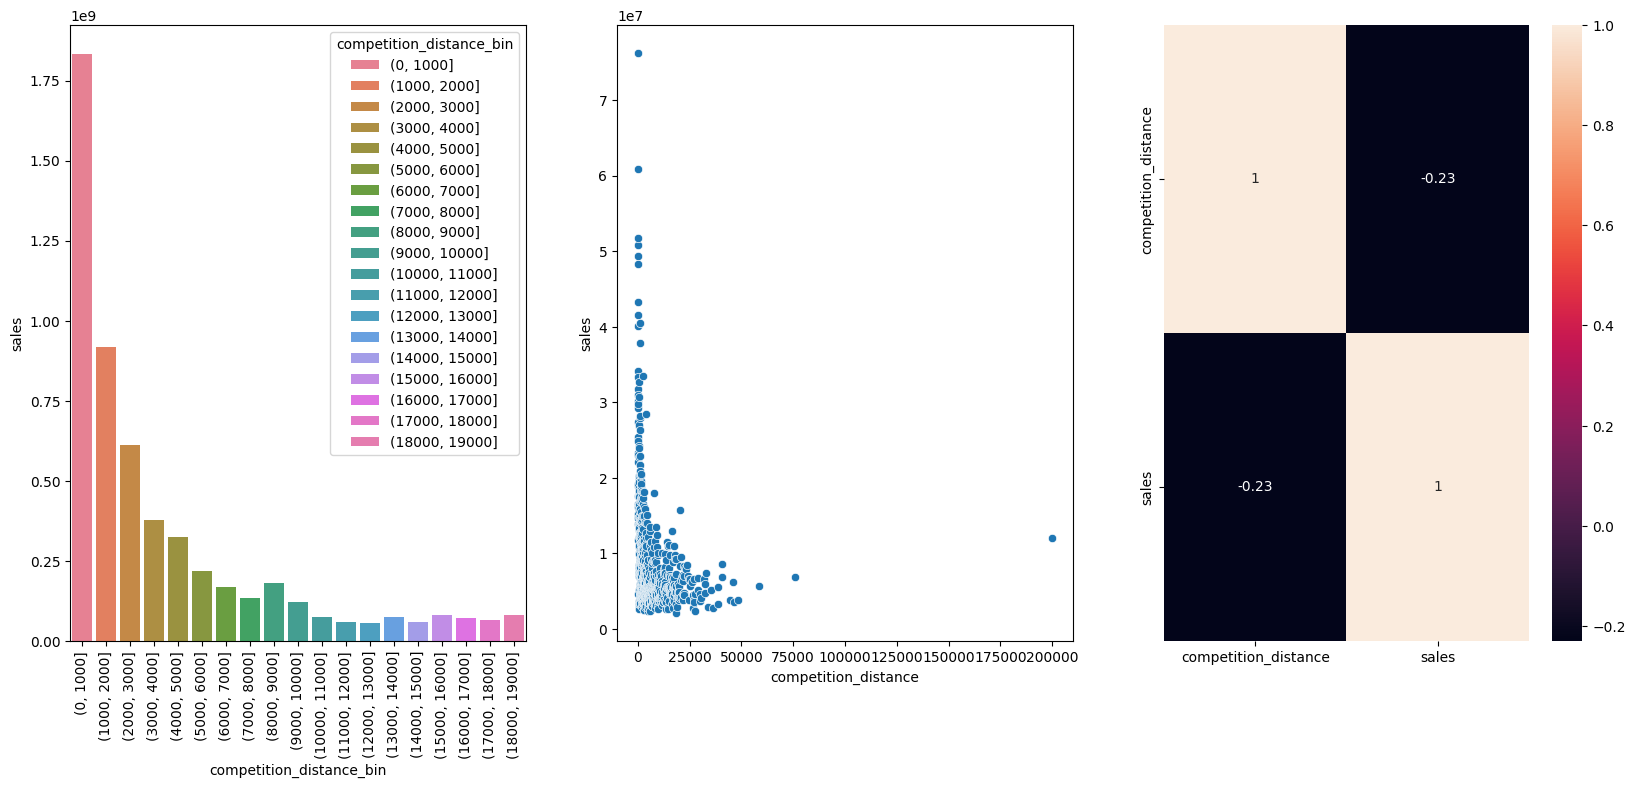

In [30]:
plt.figure(figsize=(20, 8))
plt.subplot(1,3,1)
aux1 = df4[['competition_distance', 'sales']].groupby('competition_distance').sum().reset_index()
bins = list(np.arange(0, 20000,1000))

aux1['competition_distance_bin'] = pd.cut(aux1['competition_distance'], bins=bins)
aux2 = aux1[['competition_distance_bin', 'sales']].groupby('competition_distance_bin').sum().reset_index();

sns.barplot(x='competition_distance_bin', y='sales', data=aux2, hue='competition_distance_bin');
plt.xticks(rotation=90);

plt.subplot(1,3,2)
sns.scatterplot(x='competition_distance', y='sales', data=aux1);

plt.subplot(1,3,3)
sns.heatmap(aux1[['competition_distance', 'sales']].corr(method='pearson'), annot=True);

**HIPÓTESE 3**

*Lojas com competidores à mais tempo deveriam vender mais.*

Os gráficos abaixos exibem a relação entre o tempo decorrido desde a abertura de lohas de competidores e as vendas, sendo possível notar que lojas com competidores abertos a mais tempo vendem menos. Portanto, essa hipótese é <font color="Red">**FALSA**</font>.

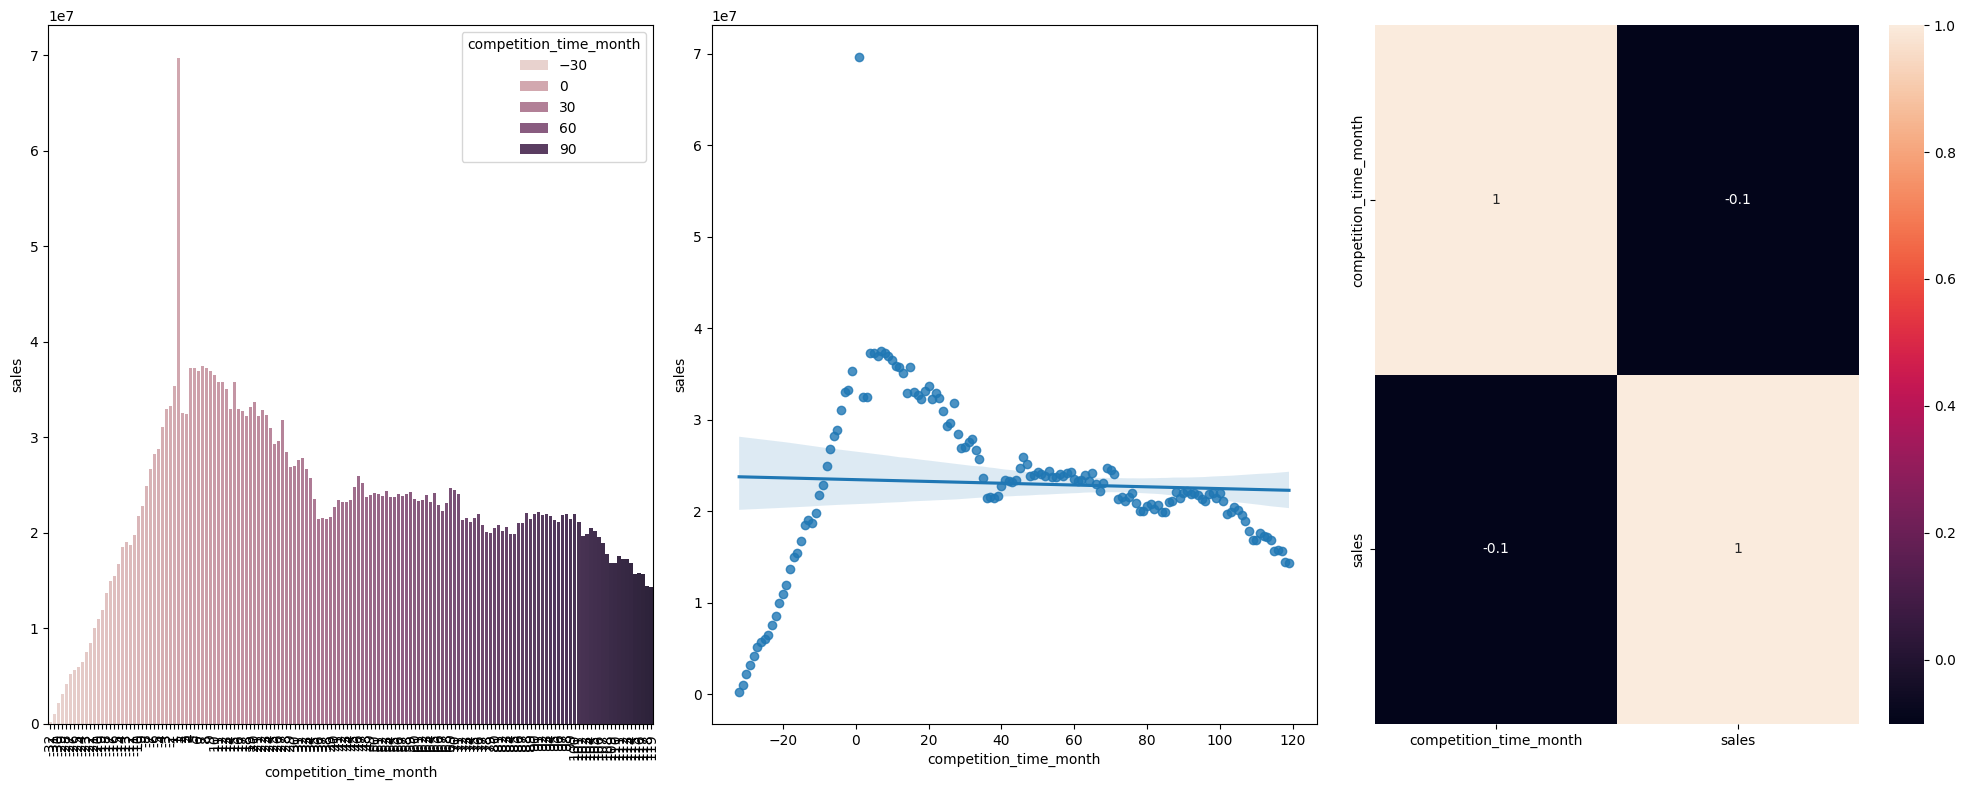

In [31]:
plt.figure(figsize=(20,8))
plt.subplot(1,3,1)
aux1 = df4[['competition_time_month', 'sales']].groupby('competition_time_month').sum().reset_index()
aux2 = aux1[(aux1['competition_time_month']<120) & (aux1['competition_time_month'] != 0)]
sns.barplot(x='competition_time_month', y='sales', data=aux2, hue='competition_time_month');
plt.xticks(rotation=90)

plt.subplot(1,3,2)
sns.regplot(x='competition_time_month', y='sales', data=aux2);

plt.subplot(1,3,3)
sns.heatmap(aux1[['competition_time_month', 'sales']].corr(method='pearson'), annot=True);

plt.tight_layout();

**HIPÓTESE 4**

*Lojas com promoções ativas por mais tempo deveriam vender mais.*

Os gráficos abaixos exibem a relação entre período de promoção e as vendas, sendo que olhamos para o período regular de promoção e para o período extendido de forma separada para entender melhor o comportamento dessa variável. Observamos que o período extendido de promoção não resulta em um volume maior de vendas e ,portanto, essa hipótese é <font color="Red">**FALSA**</font>.

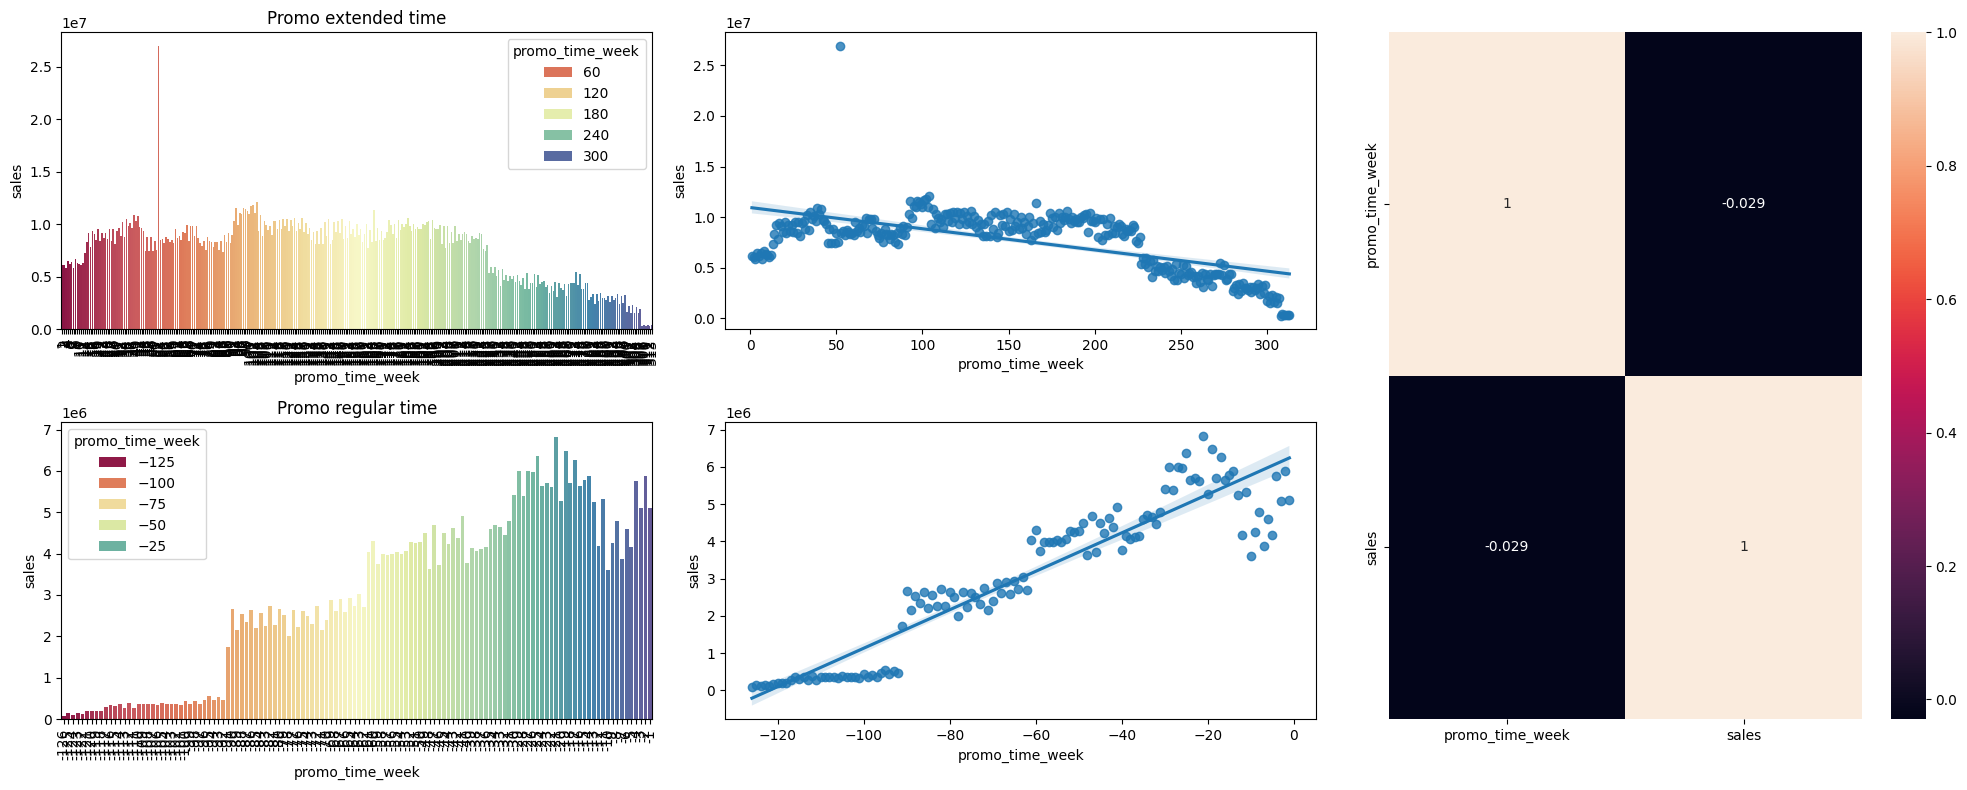

In [32]:
aux1 = df4[['promo_time_week', 'sales']].groupby('promo_time_week').sum().reset_index()
plt.figure(figsize=(20,8))

grid = GridSpec(2,3)

# periodo extendido de promocao
plt.subplot(grid[0,0])
aux2 = aux1[aux1['promo_time_week']>0] 
sns.barplot(x='promo_time_week', y='sales', data=aux2, hue='promo_time_week', palette='Spectral');
plt.xticks(rotation=90);
plt.title('Promo extended time');

plt.subplot(grid[0,1])
sns.regplot(x='promo_time_week', y='sales', data=aux2);

# periodo regular de promocao
plt.subplot(grid[1,0])
aux3 = aux1[aux1['promo_time_week']<0]
sns.barplot(x='promo_time_week', y='sales', data=aux3, hue='promo_time_week', palette='Spectral');
plt.xticks(rotation=90);
plt.title('Promo regular time');

plt.subplot(grid[1,1])
sns.regplot(x='promo_time_week', y='sales', data=aux3);

plt.subplot(grid[:,2])
sns.heatmap(aux1[['promo_time_week', 'sales']].corr(method='pearson'), annot=True);

plt.tight_layout();

**HIPÓTESE 5**

*Lojas com mais dias de promoção deveriam vender mais.*

<font color="Blue">**Essa hipótese será analisada em uma próxima etapa de desenvolvimento do projeto, seguindo a linha de desenvolvimento do CRISP.**</font>

**HIPÓTESE 6**

*Lojas com mais promoções consecutivas deveriam vender mais.*

A tabela e o gráfico abaixo exibem a relação entre tempo de participação em promoções e as vendas, sendo possível notar que lojas que participaram da promoção extendida não venderam mais. Portanto, essa hipótese é <font color="Red">**FALSA**</font>.

In [33]:
df4[['promo', 'promo2', 'sales']].groupby(['promo', 'promo2']).sum().reset_index().sort_values('sales', ascending=False)


,promo,promo2,sales
2,1,0,1628930532
0,0,0,1482612096
3,1,1,1472275754
1,0,1,1289362241


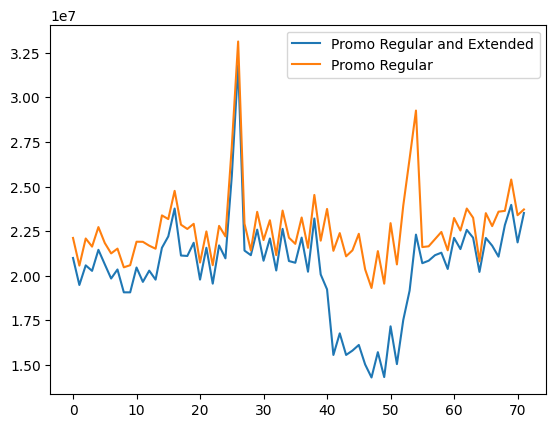

In [34]:
aux1 = df4[(df4['promo']==1) & (df4['promo2'] ==1)][['year_week', 'sales']].groupby('year_week').sum().reset_index()
ax = aux1.plot()

aux2 = df4[(df4['promo']==1) & (df4['promo2'] ==0)][['year_week', 'sales']].groupby('year_week').sum().reset_index()
aux2.plot(ax=ax)

ax.legend(labels=['Promo Regular and Extended', 'Promo Regular'])

**HIPÓTESE 7**

*Lojas abertas durante o feriado de Natal deveriam vender mais.*

Os gráficos abaixo exibem a relação entre feriados e vendas, sendo possível notar que as lojas não vendem mais no feriado de Natal. Portanto, essa hipótese é <font color="Red">**FALSA**</font>.

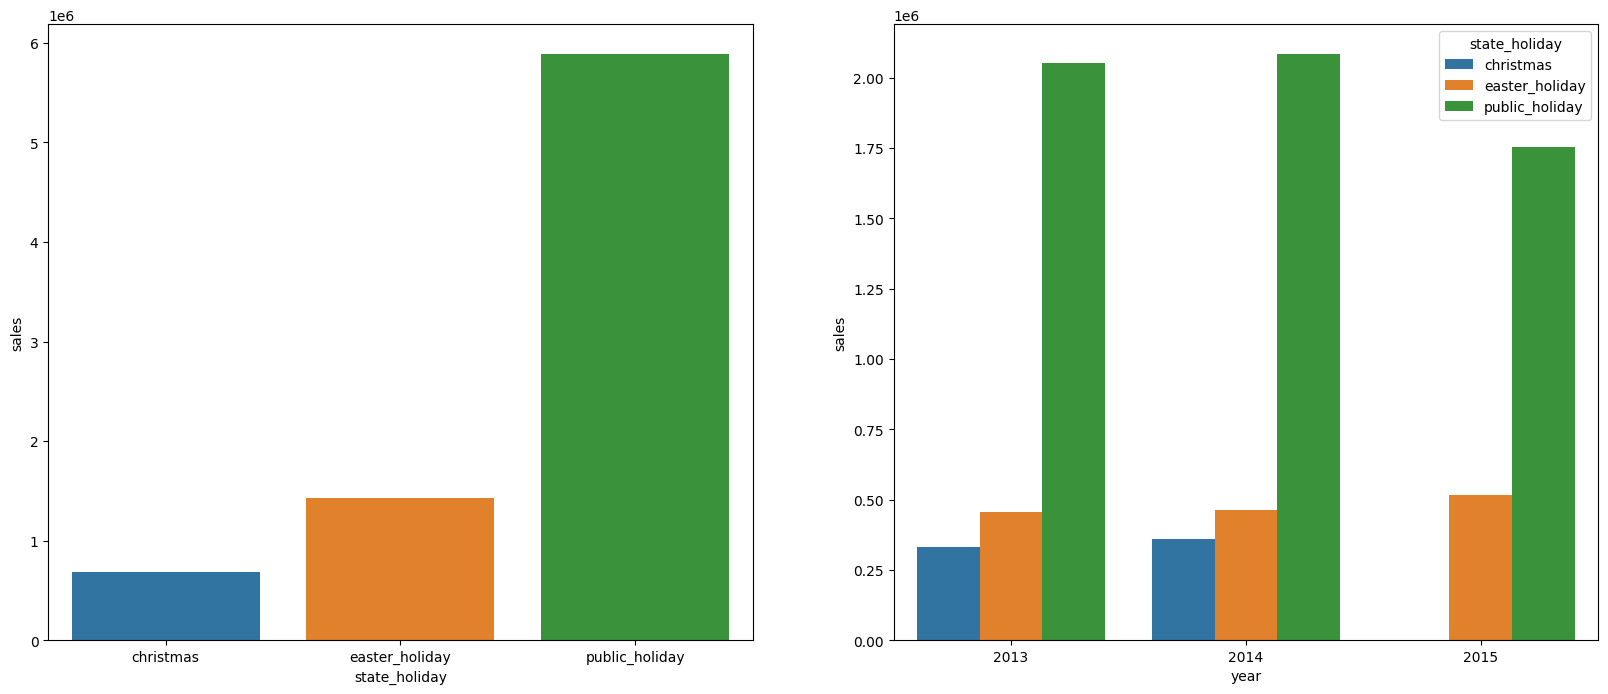

In [35]:
aux = df4[df4['state_holiday'] != 'regular_day']
plt.figure(figsize=(20,8))

plt.subplot(1,2,1)
aux1 = aux[['state_holiday', 'sales']].groupby('state_holiday').sum().reset_index()     
sns.barplot(x='state_holiday', y='sales', data=aux1, hue='state_holiday');

plt.subplot(1,2,2)
aux2 = aux[['year', 'state_holiday', 'sales']].groupby(['year', 'state_holiday']).sum().reset_index()
sns.barplot(x='year', y='sales', data=aux2, hue='state_holiday');

**HIPÓTESE 8**

*Lojas deveriam vender mais ao longo dos anos.*

Os gráficos abaixo exibem a relação entre os anos e as vendas, sendo possível notar que as lojas apresentam um declínio nas vendas. Portanto, essa hipótese é <font color="Red">**FALSA**</font>.

**NOTA**: é importante lembrar que o conjunto de dados não possui informações sobre as vendas até o final do ano de 2015.

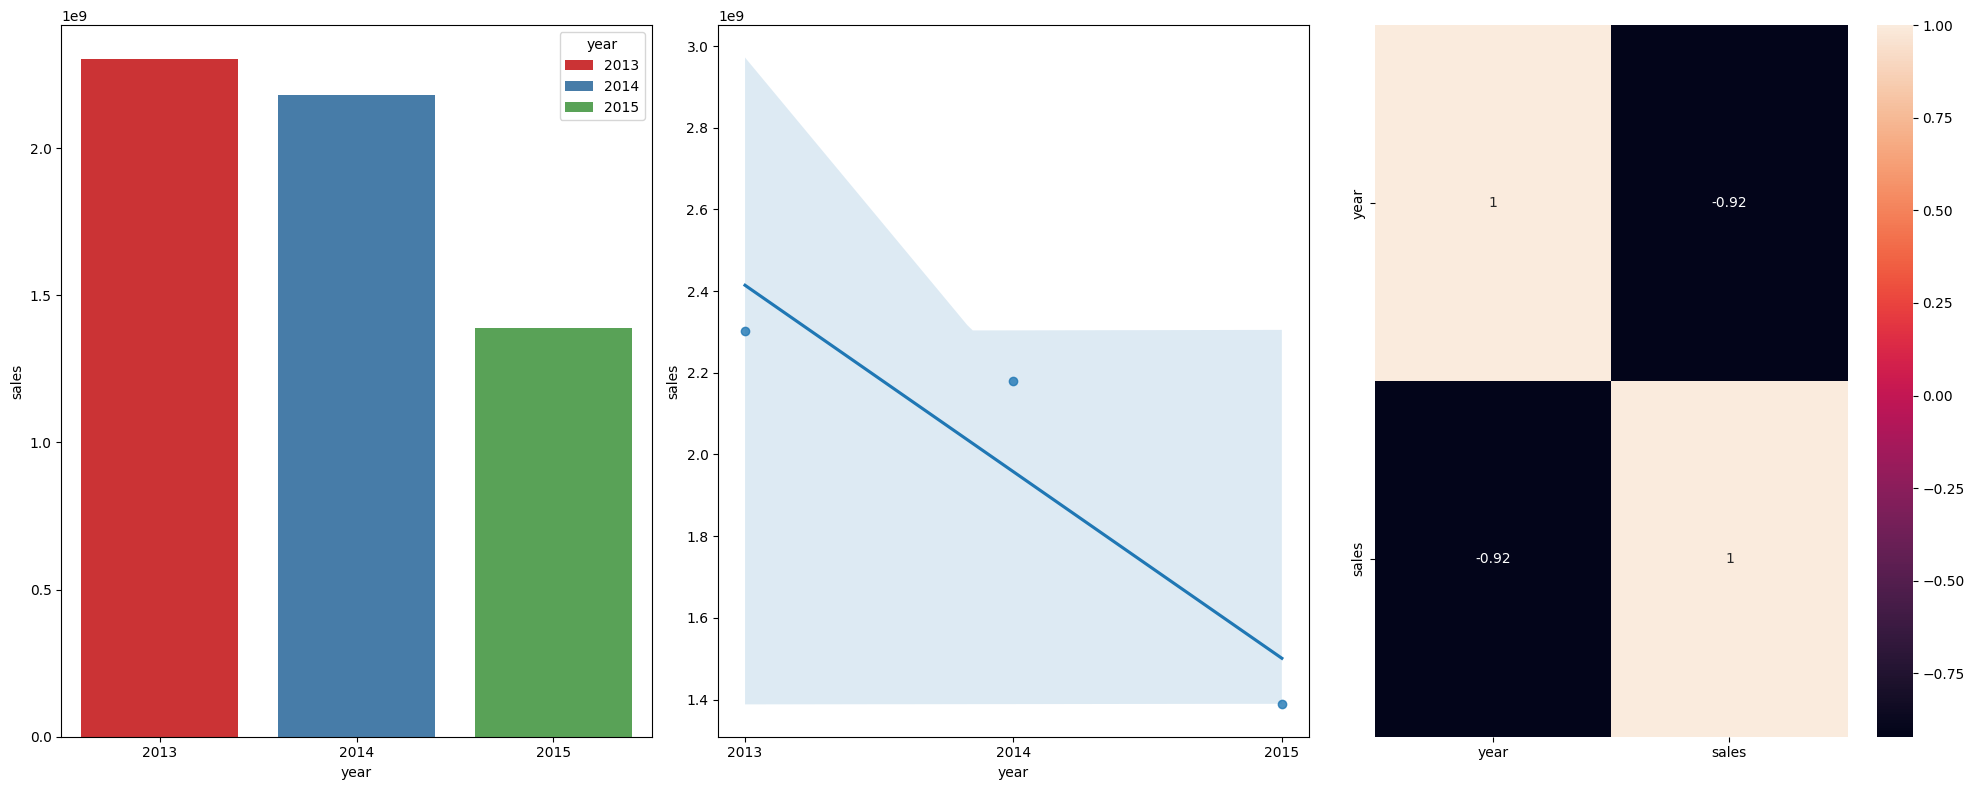

In [36]:
aux1 = df4[['year', 'sales']].groupby('year').sum().reset_index()
plt.figure(figsize=(20,8))

plt.subplot(1,3,1)
sns.barplot(x='year', y='sales', data=aux1, hue='year', palette='Set1');

plt.subplot(1,3,2)
sns.regplot(data=aux1,x='year', y='sales')
plt.xticks(ticks=aux1['year']);

plt.subplot(1,3,3)
sns.heatmap(aux1[['year', 'sales']].corr(method='pearson'), annot=True);

plt.tight_layout()

**HIPÓTESE 9**

*Lojas deveriam vender mais no segundo semestre do ano.*

Se analisarmos todo o conjunto de dados disponível, veremos que os meses do segundo semestre vendem menos. Porém, se analisarmos somente os anos completos (2013 e 2014), notamos que temos um aumento nas vendas no segundo semestre. Portanto, essa hipótese é <font color="Red">**FALSA**</font> quando consideramos todo o dataset, porém é <font color="Green">**VERDADEIRA**</font> se considerarmos somente os anos completos.

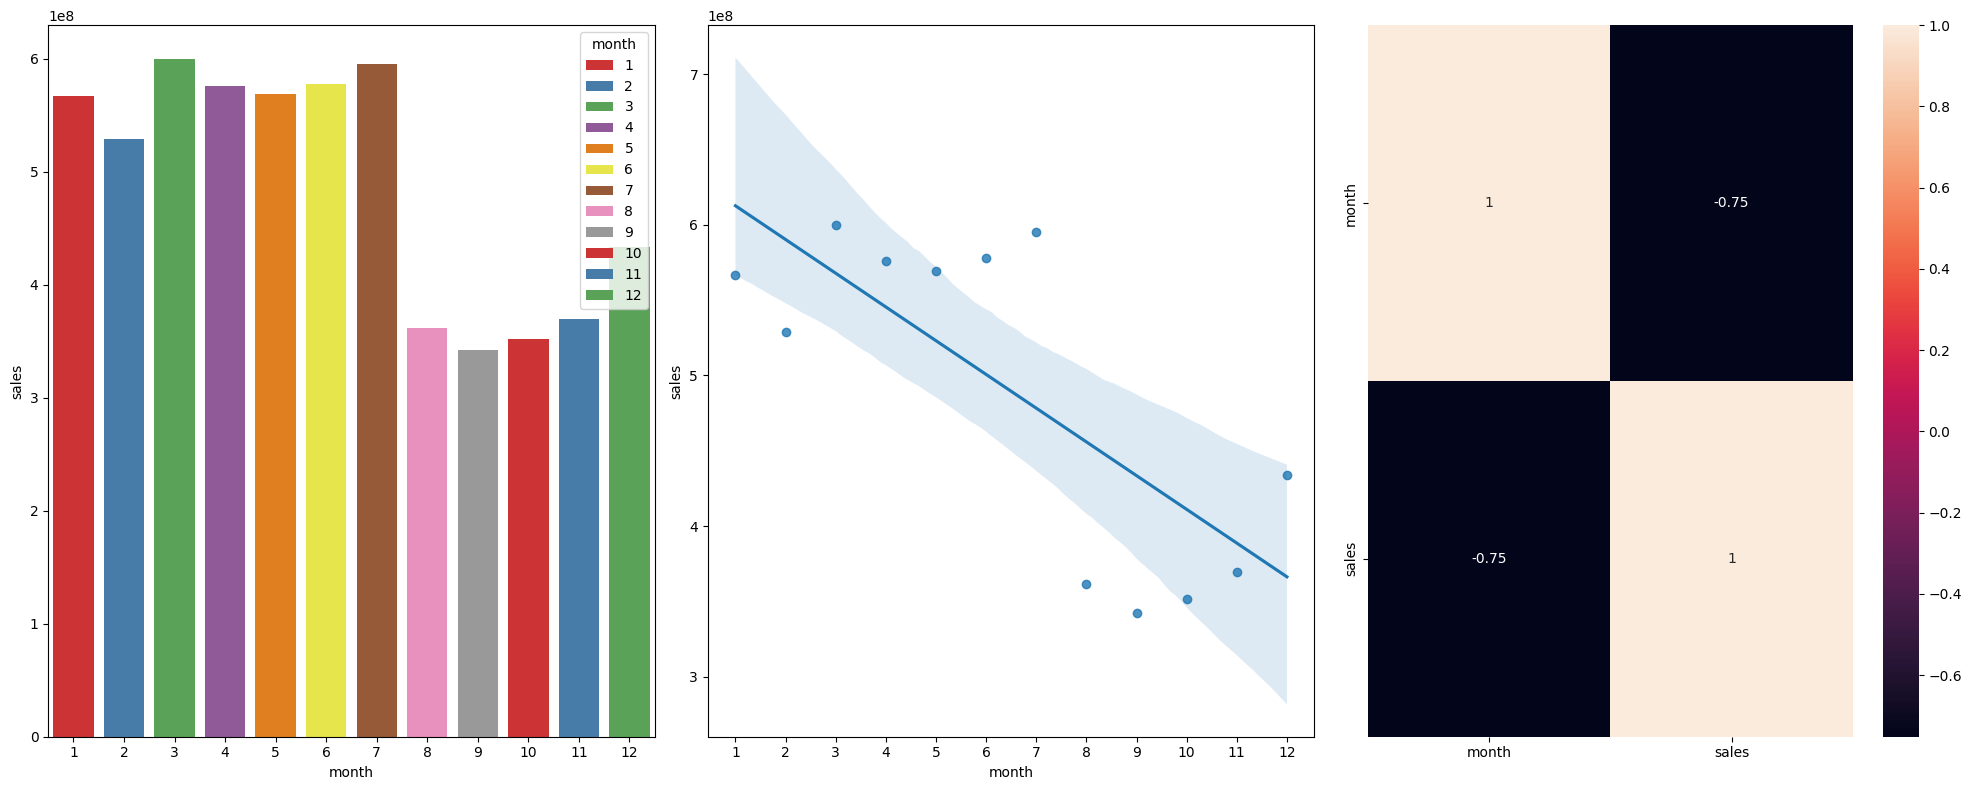

In [37]:
aux1 = df4[['month', 'sales']].groupby('month').sum().reset_index()
plt.figure(figsize=(20,8))

plt.subplot(1,3,1)
sns.barplot(x='month', y='sales', data=aux1, hue='month', palette='Set1');

plt.subplot(1,3,2)
sns.regplot(data=aux1,x='month', y='sales')
plt.xticks(ticks=aux1['month']);

plt.subplot(1,3,3)
sns.heatmap(aux1[['month', 'sales']].corr(method='pearson'), annot=True);

plt.tight_layout()

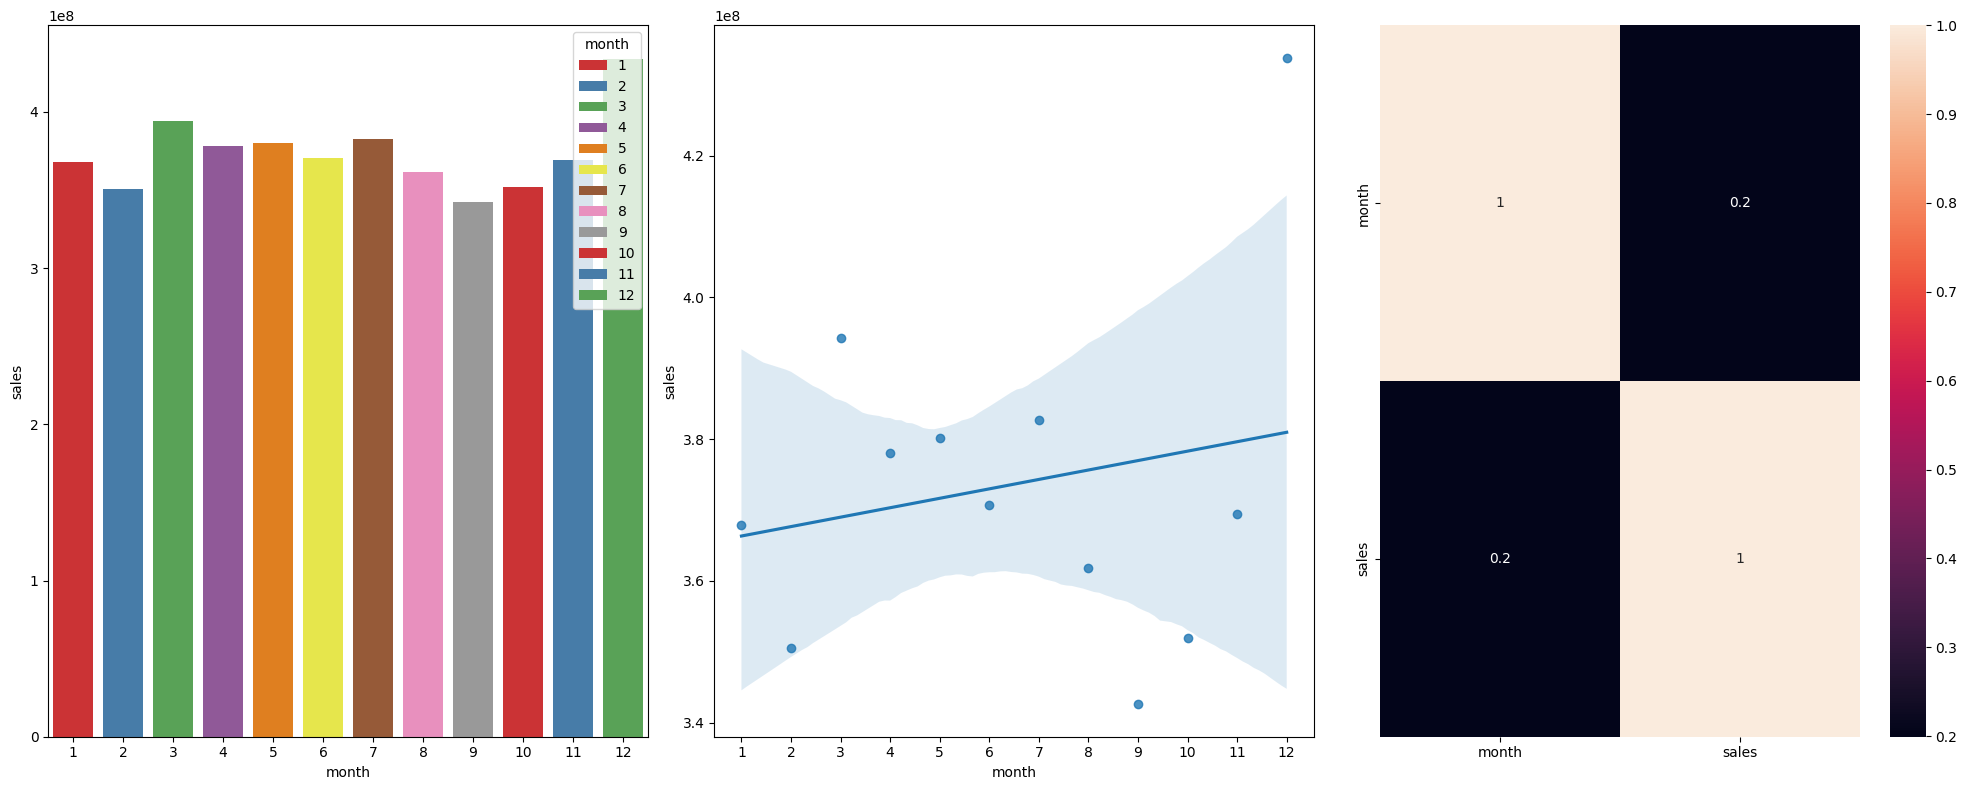

In [38]:
df_filtrado = df4[df4['year'] != 2015]
aux1 = df_filtrado[['month', 'sales']].groupby('month').sum().reset_index()
plt.figure(figsize=(20,8))

plt.subplot(1,3,1)
sns.barplot(x='month', y='sales', data=aux1, hue='month', palette='Set1');

plt.subplot(1,3,2)
sns.regplot(data=aux1,x='month', y='sales')
plt.xticks(ticks=aux1['month']);

plt.subplot(1,3,3)
sns.heatmap(aux1[['month', 'sales']].corr(method='pearson'), annot=True);

plt.tight_layout()

**HIPÓTESE 10**

*Lojas deveriam vender mais depois do dia 10 de cada mês.*

Os gráficos abaixo exibem a relação entre as vendas antes do dia 10 de cada mês e dedois do dia 10 de cada mês, sendo possível verificar que as lojas vendem mais depois do dia 10 de cada mês. Portanto, essa hipótese é <font color="Green">**VERDADEIRA**</font>.

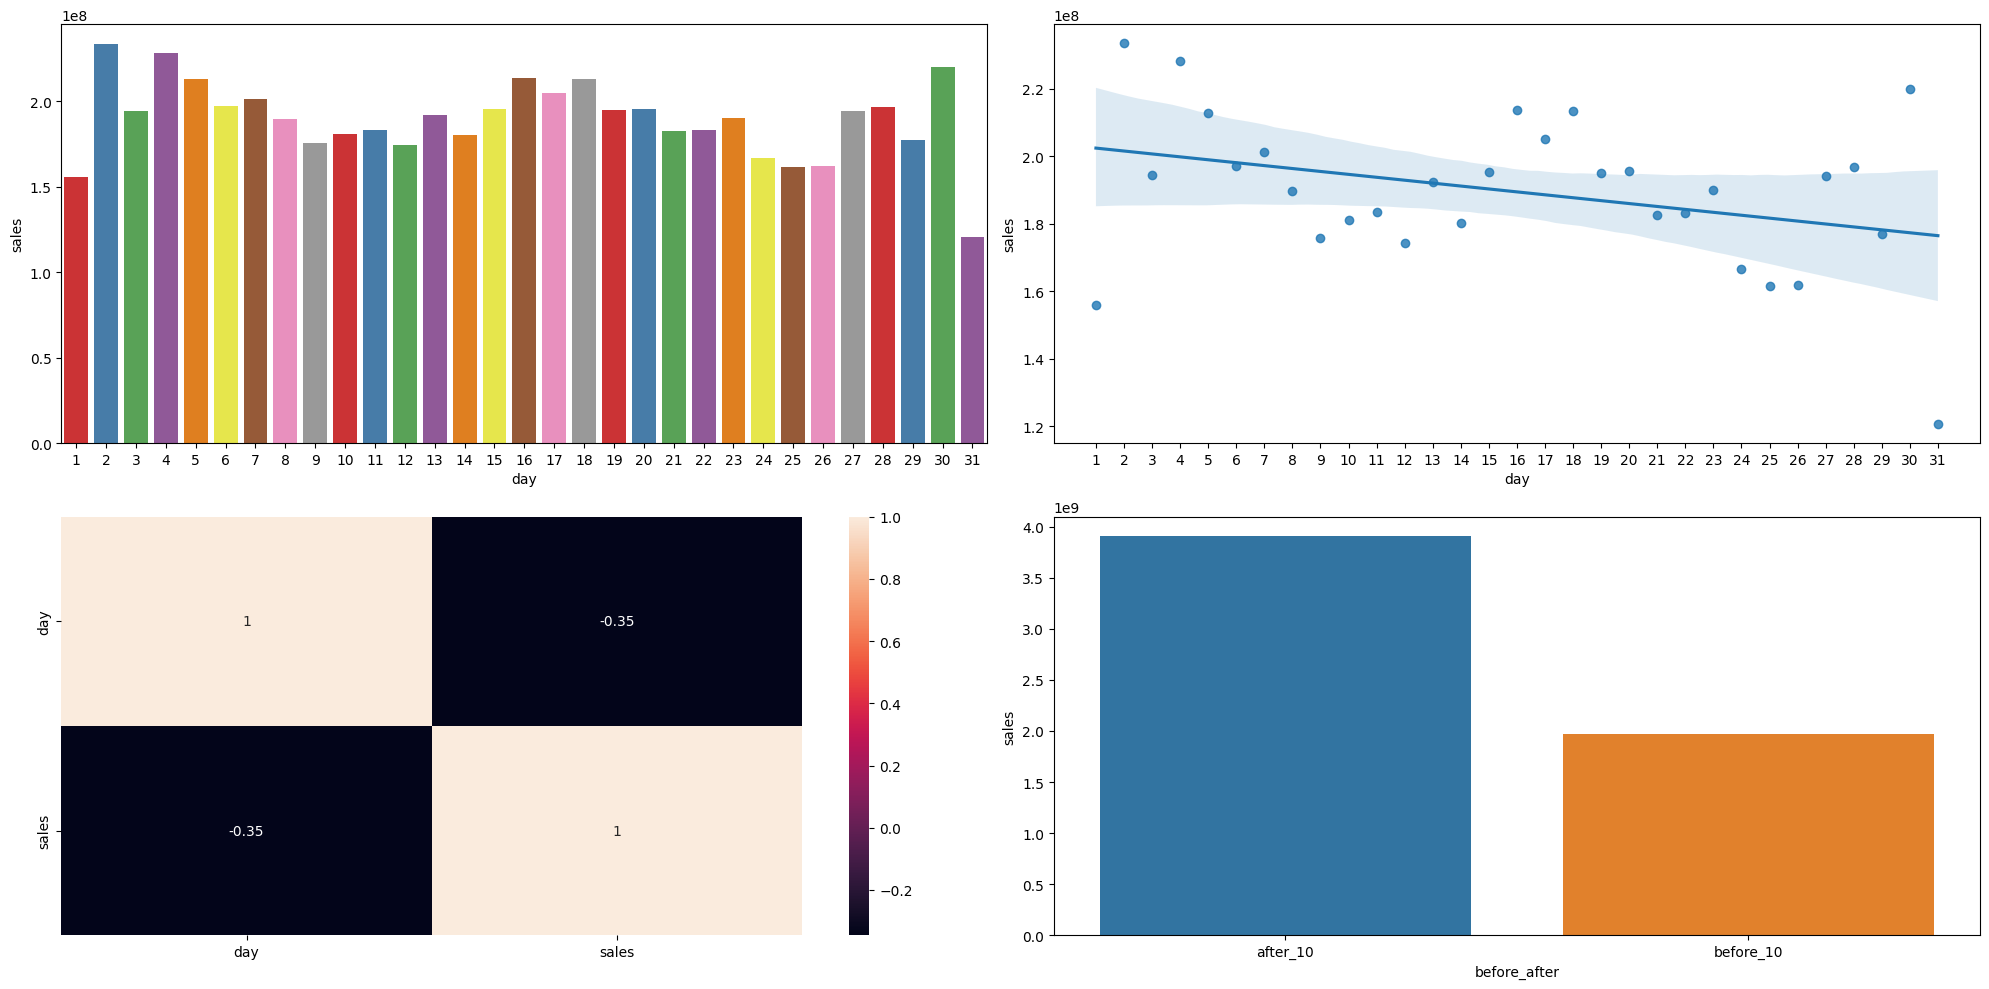

In [39]:
aux1 = df4[['day', 'sales']].groupby('day').sum().reset_index()
plt.figure(figsize=(20,10))

plt.subplot(2,2,1)
sns.barplot(x='day', y='sales', data=aux1, hue='day', palette='Set1', legend=False);

plt.subplot(2,2,2)
sns.regplot(data=aux1,x='day', y='sales')
plt.xticks(ticks=aux1['day']);

plt.subplot(2,2,3)
sns.heatmap(aux1[['day', 'sales']].corr(method='pearson'), annot=True);

plt.subplot(2,2,4)
aux1['before_after'] = aux1['day'].apply(lambda x: 'before_10' if x <= 10 else 'after_10')
aux2 = aux1[['before_after', 'sales']].groupby('before_after').sum().reset_index()
sns.barplot(x='before_after', y='sales', data=aux2, hue='before_after');

plt.tight_layout()


**HIPÓTESE 11**

*Lojas deveriam vender menos aos finais de semana.*

Os gráficos abaixo exibem as vendas de acordo com os dias da semana, sendo possível notar que as lojas vendem menos no final de semana (dias 6 e 7) do que nos dias da semana (dias de 1 a 5). Portanto, essa hipótese é <font color="Red">**FALSA**</font>.

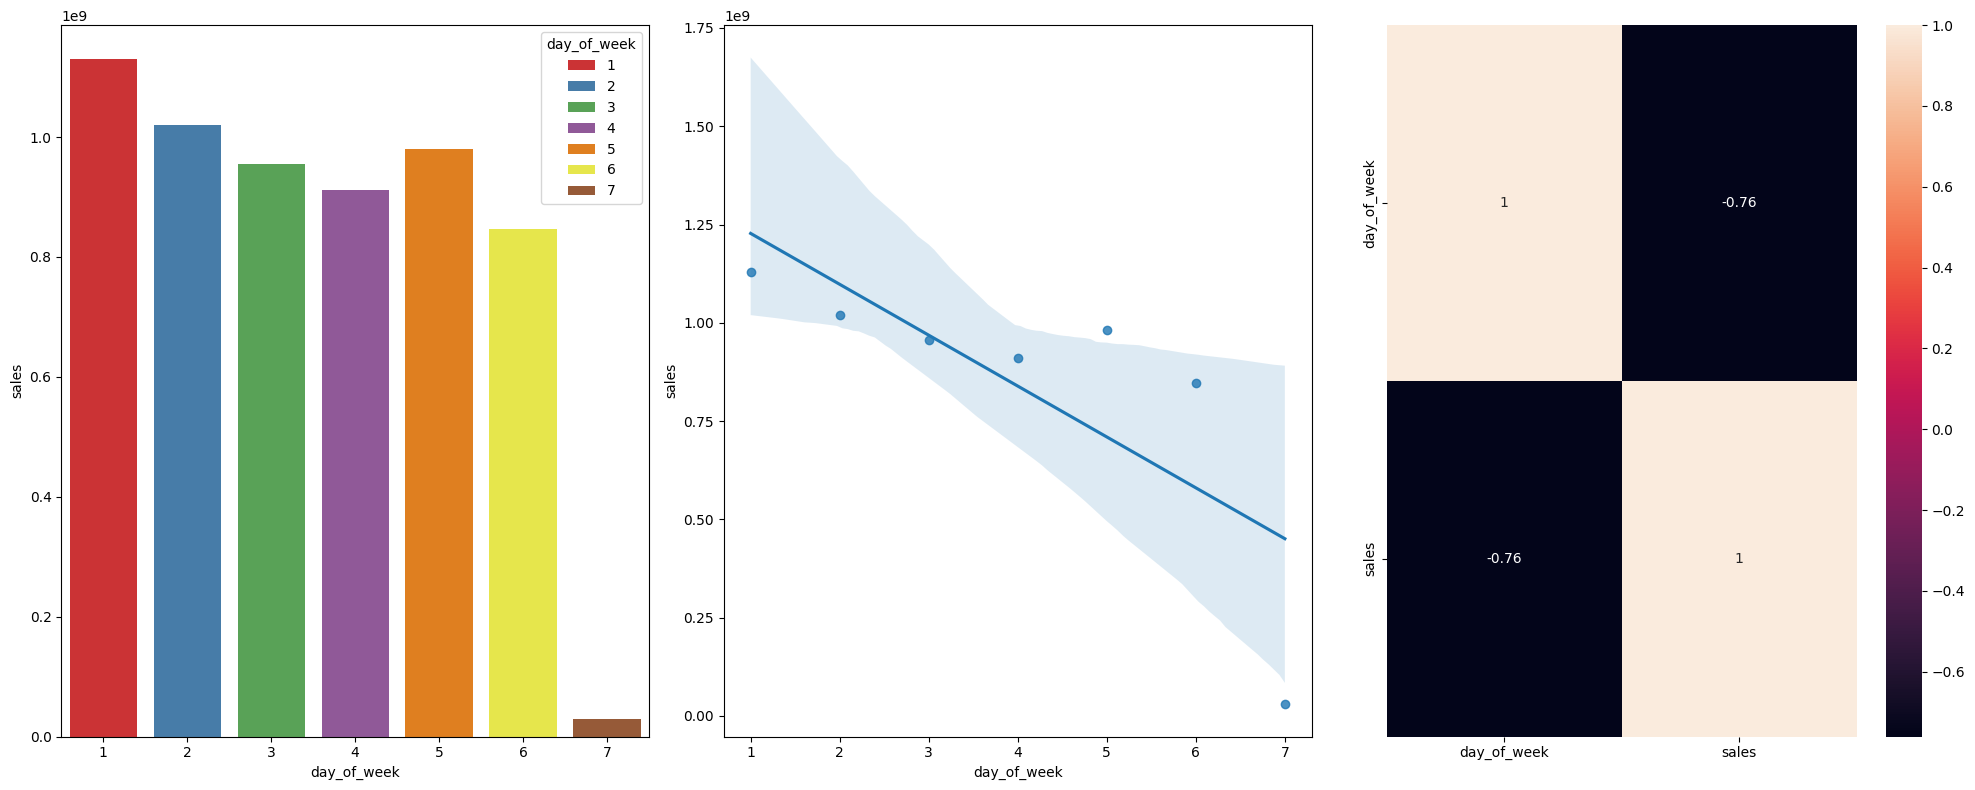

In [40]:
aux1 = df4[['day_of_week', 'sales']].groupby('day_of_week').sum().reset_index()
plt.figure(figsize=(20,8))

plt.subplot(1,3,1)
sns.barplot(x='day_of_week', y='sales', data=aux1, hue='day_of_week', palette='Set1');

plt.subplot(1,3,2)
sns.regplot(data=aux1,x='day_of_week', y='sales')
plt.xticks(ticks=aux1['day_of_week']);

plt.subplot(1,3,3)
sns.heatmap(aux1[['day_of_week', 'sales']].corr(method='pearson'), annot=True);

plt.tight_layout()

**HIPÓTESE 12**

*Lojas deveriam vender menos durante os feriados escolares.*

Os gráficos abaixo mostram a relação entre vendas durante os feriados escolares e em períodos de aula regular, sendo possível notar que as lojas vendam menos durante os feriados escolares, exceto pelos meses de Julho e Agosto. Portanto, essa hipótese é <font color="Green">**VERDADEIRA**</font>.

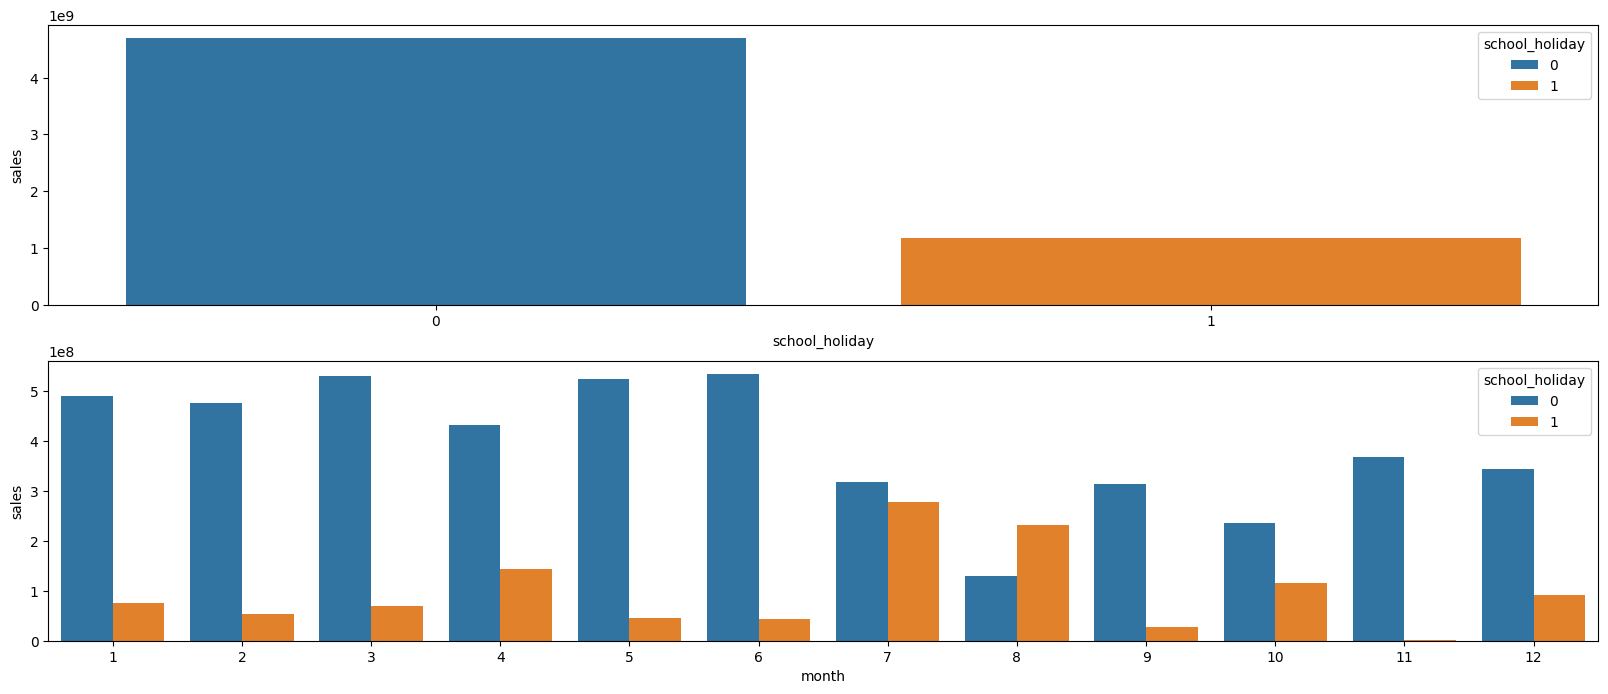

In [41]:
plt.figure(figsize=(20,8))
plt.subplot(2,1,1)
aux1 = df4[['school_holiday', 'sales']].groupby('school_holiday').sum().reset_index()
sns.barplot(x='school_holiday', y='sales', data=aux1, hue='school_holiday');

plt.subplot(2,1,2)
aux2 = df4[['month', 'school_holiday', 'sales']].groupby(['month', 'school_holiday']).sum().reset_index()
sns.barplot(x='month', y='sales', data=aux2, hue='school_holiday');

### Resumo das hipóteses

In [42]:
tab = [['Hipoteses', 'Conclusão', 'Relevância'],
       ['H1', 'Falsa', 'Baixa'],
       ['H2', 'Falsa', 'Media'],
       ['H3', 'Falsa', 'Media'],
       ['H4', 'Falsa', 'Baixa'],
       ['H5', '-', '-'],
       ['H6', 'Falsa', 'Baixa'],
       ['H7', 'Falsa', 'Media'],
       ['H8', 'Falsa', 'Alta'],
       ['H9', 'Falsa/Verdadeira', 'Alta'],
       ['H10', 'Verdadeira', 'Alta'],
       ['H11', 'Falsa', 'Alta'],
       ['H12', 'Verdadeira', 'Baixa'],
       ]

print(tabulate(tab, headers='firstrow', tablefmt='fancy_grid'))

╒═════════════╤══════════════════╤══════════════╕
│ Hipoteses   │ Conclusão        │ Relevância   │
╞═════════════╪══════════════════╪══════════════╡
│ H1          │ Falsa            │ Baixa        │
├─────────────┼──────────────────┼──────────────┤
│ H2          │ Falsa            │ Media        │
├─────────────┼──────────────────┼──────────────┤
│ H3          │ Falsa            │ Media        │
├─────────────┼──────────────────┼──────────────┤
│ H4          │ Falsa            │ Baixa        │
├─────────────┼──────────────────┼──────────────┤
│ H5          │ -                │ -            │
├─────────────┼──────────────────┼──────────────┤
│ H6          │ Falsa            │ Baixa        │
├─────────────┼──────────────────┼──────────────┤
│ H7          │ Falsa            │ Media        │
├─────────────┼──────────────────┼──────────────┤
│ H8          │ Falsa            │ Alta         │
├─────────────┼──────────────────┼──────────────┤
│ H9          │ Falsa/Verdadeira │ Alta         │


### 5.3 Análise Multivariada

**VARIÁVEIS NUMÉRICAS**

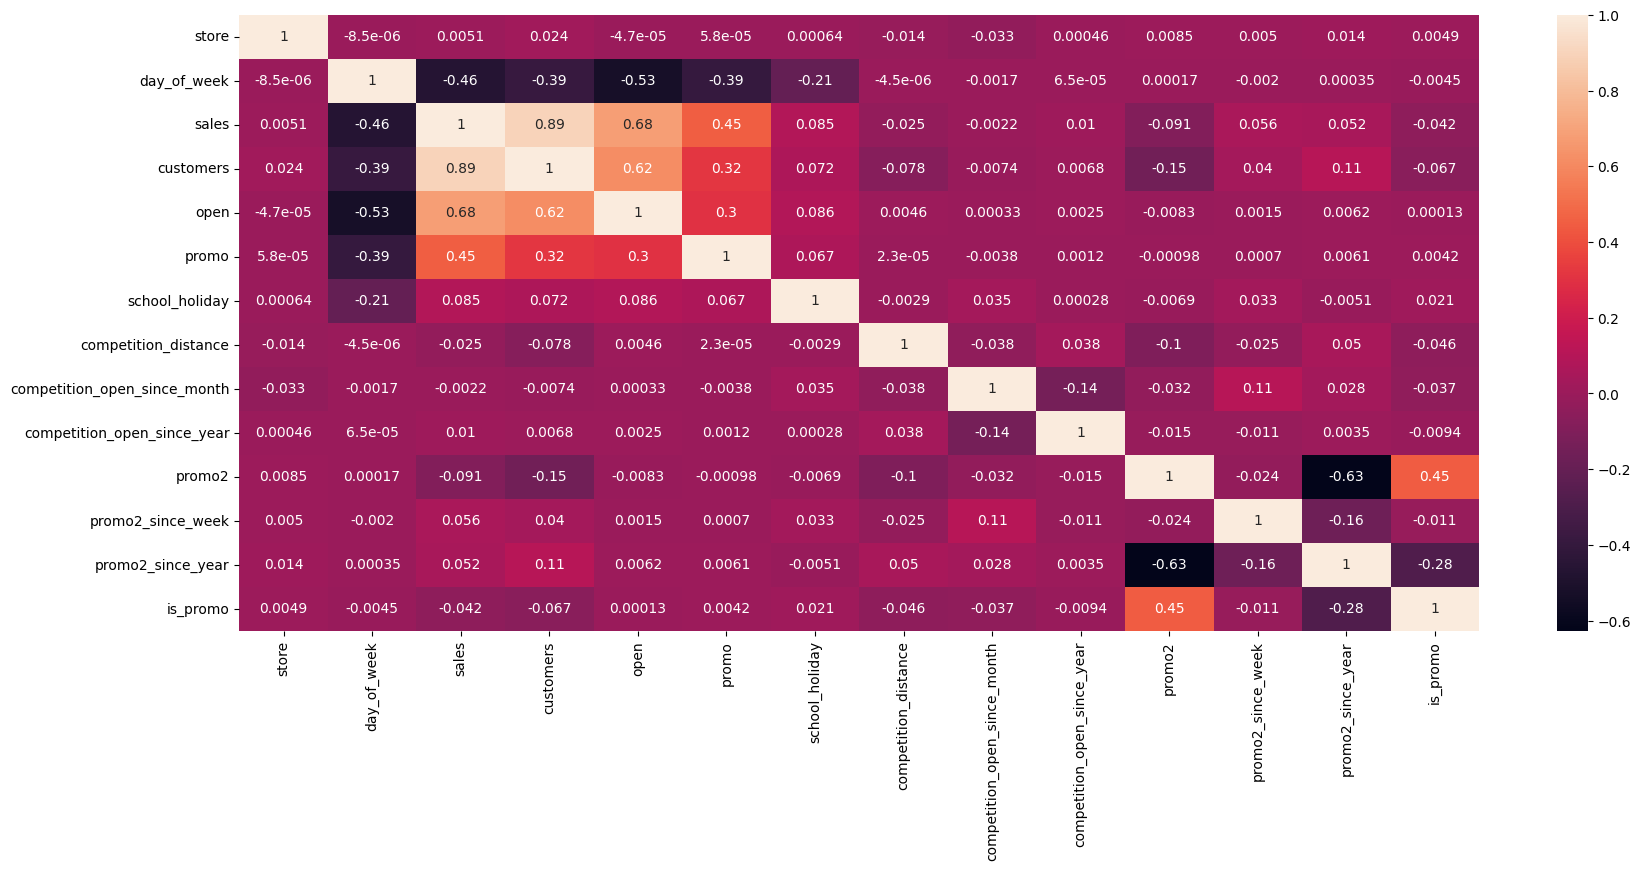

In [43]:
correlation = num_attributes.corr(method='pearson')
plt.figure(figsize=(20,8))
sns.heatmap(correlation, annot=True);

**VARIÁVEIS CATEGÓRICAS**

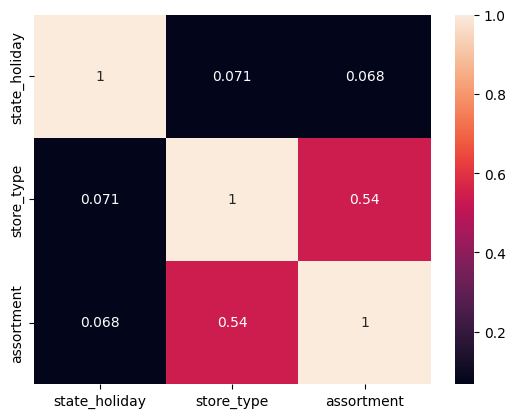

In [44]:
cat_variables = df4.select_dtypes(include=['object'])

# Lista de colunas para calcular Cramér's V
columns = ['state_holiday', 'store_type', 'assortment']

# Calcular Cramér's V para todas as combinações
cramer_matrix = {
    col1: [cramer_v(cat_variables[col1], cat_variables[col2]) for col2 in columns]
    for col1 in columns
}

# Criar o DataFrame final
d = pd.DataFrame(cramer_matrix, index=columns)

sns.heatmap(d, annot = True);


# 6. Preparação dos dados

In [45]:
df5 = df4.copy()

**NORMALIZAÇÃO**

Como nenhuma feature apresentou distribuição normal (avaliada na análise univariada), não será aplicada normalização.

**RESCALING**

In [46]:
aux = df5.select_dtypes(include=['int64', 'float64'])
aux.head()

,store,day_of_week,sales,promo,school_holiday,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,competition_time_month,promo_time_week
0,1,5,5263,1,1,1270.0,9,2008,0,31,2015,0,84,0
1,2,5,6064,1,1,570.0,11,2007,1,13,2010,1,94,279
2,3,5,8314,1,1,14130.0,12,2006,1,14,2011,1,105,226
3,4,5,13995,1,1,620.0,9,2009,0,31,2015,0,71,0
4,5,5,4822,1,1,29910.0,4,2015,0,31,2015,0,4,0


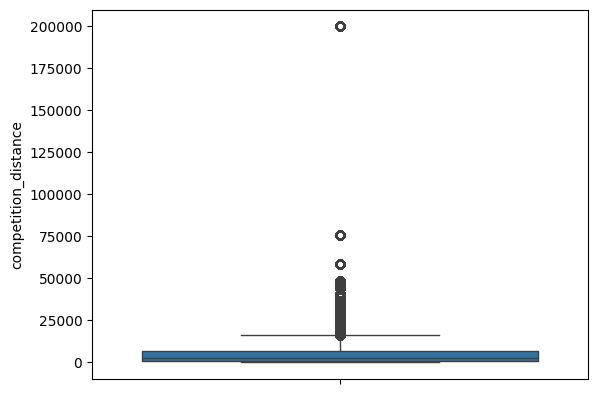

In [47]:
# Competition distance
# Conferindo o comportamento dos outliers
sns.boxplot(df5['competition_distance'])

# Aplicando RobustScaler
rs = RobustScaler()
df5['competition_distance'] = rs.fit_transform(df5[['competition_distance']].values)


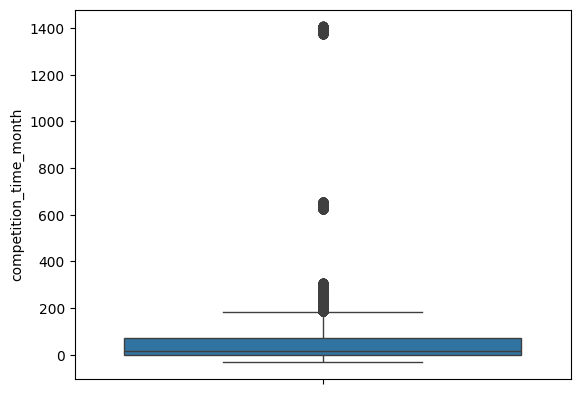

In [48]:
# Competition time month
# Conferindo o comportamento dos outliers
sns.boxplot(df5['competition_time_month'])

# Aplicando RobustScaler
df5['competition_time_month'] = rs.fit_transform(df5[['competition_time_month']].values)

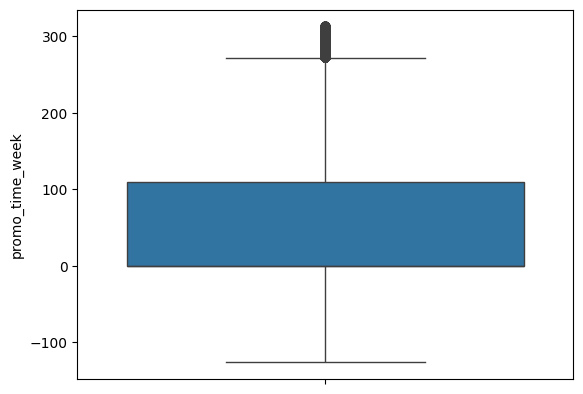

In [49]:
# Promo time week
# Conferindo o comportamento dos outliers
sns.boxplot(df5['promo_time_week'])

# Aplicando MinMaxScaler
mms = MinMaxScaler()
df5['promo_time_week'] = mms.fit_transform(df5[['promo_time_week']].values)

In [50]:
# Year
# Aplicando MinMaxScaler
df5['year'] = mms.fit_transform(df5[['year']].values)

**TRANSFORMAÇÃO**

In [51]:
# Store holiday - One Hot Encoding
df5 = pd.get_dummies(df5, prefix=['state_holiday'], columns=['state_holiday'])

# Store type
le = LabelEncoder()
df5['store_type'] = le.fit_transform(df5['store_type'])

# Assortment - Ordinal Encoding
assortment_dic = {'basic': 1, 'extra': 2, 'extended': 3}
df5['assortment'] = df5['assortment'].map(assortment_dic)

In [52]:
# Transformacao da Variavel resposta
df5['sales'] = np.log1p(df5['sales'])

In [53]:
# Transformacao de natureza

# Day of week
df5['day_of_week_sin'] = df5['day_of_week'].apply(lambda x: np.sin(x * (2. * np.pi / 7)))
df5['day_of_week_cos'] = df5['day_of_week'].apply(lambda x: np.cos(x * (2. * np.pi / 7)))

# Month
df5['month_sin'] = df5['month'].apply(lambda x: np.sin(x * (2. * np.pi / 12)))
df5['month_cos'] = df5['month'].apply(lambda x: np.cos(x * (2. * np.pi / 12)))

# Day
df5['day_sin'] = df5['day'].apply(lambda x: np.sin(x * (2. * np.pi / 30)))
df5['day_cos'] = df5['day'].apply(lambda x: np.cos(x * (2. * np.pi / 30)))

# Week of year
df5['week_of_year_sin'] = df5['week_of_year'].apply(lambda x: np.sin(x * (2. * np.pi / 52)))
df5['week_of_year_cos'] = df5['week_of_year'].apply(lambda x: np.cos(x * (2. * np.pi / 52)))


In [54]:
df5.head()

,store,day_of_week,date,sales,promo,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,...,state_holiday_public_holiday,state_holiday_regular_day,day_of_week_sin,day_of_week_cos,month_sin,month_cos,day_sin,day_cos,week_of_year_sin,week_of_year_cos
0,1,5,2015-07-31,8.568646,1,1,2,1,-0.170968,9,...,False,True,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984
1,2,5,2015-07-31,8.710290,1,1,0,1,-0.283871,11,...,False,True,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984
2,3,5,2015-07-31,9.025816,1,1,0,1,1.903226,12,...,False,True,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984
3,4,5,2015-07-31,9.546527,1,1,2,3,-0.275806,9,...,False,True,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984
4,5,5,2015-07-31,8.481151,1,1,0,1,4.448387,4,...,False,True,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984


# 7. Feature Selection

In [55]:
df6 = df5.copy()

In [56]:
# Selecionar colunas  para exclusao
col_drop = ['week_of_year', 'month', 'day', 'day_of_week', 'promo_since', 'competition_since', 'year_week']

# Deletar colunas
df6 = df6.drop(col_drop, axis=1)

# Verificar datas para a divisao do dataset
df6[['store', 'date']].groupby('store').max().reset_index()['date'][0] - datetime.timedelta(days=6*7)

Timestamp('2015-06-19 00:00:00')

In [57]:
# Train Test split
X_train = df6[df6['date'] < '2015-06-19']
y_train = X_train['sales']

X_test = df6[df6['date'] >= '2015-06-19']
y_test = X_test['sales']

print(f'Training Min Date: {X_train["date"].min()}')
print(f'Training Max Date: {X_train["date"].max()}')
print(f'Test Min Date: {X_test["date"].min()}')
print(f'Test Max Date: {X_test["date"].max()}')


Training Min Date: 2013-01-01 00:00:00
Training Max Date: 2015-06-18 00:00:00
Test Min Date: 2015-06-19 00:00:00
Test Max Date: 2015-07-31 00:00:00


**BORUTA**

O algoritmo Boruta será executado uma vez para gerar uma lista de features relevantes, de acordo com os parâmetros desse algoritmo.

In [58]:
# Selecionar colunas para treinamento
# X_train_n = X_train.drop(['date', 'sales'], axis=1).values
# y_train_n = y_train.values.ravel()

# Instanciar RandomForest
# rf = RandomForestRegressor(n_jobs=-1)

# Instanciar Boruta
# boruta = BorutaPy(rf, n_estimators='auto', verbose=2, random_state=42).fit(X_train_n, y_train_n)

In [59]:
# Ranking das features
# features_selected = boruta.support_.tolist()

# X_train_fs = X_train.drop(['date', 'sales'], axis=1)
# features_selected_boruta = X_train_fs.iloc[:, features_selected].columns.to_list() 

# features_not_selected_boruta = list(np.setdiff1d(X_train_fs.columns, features_selected_boruta)) 

In [60]:
# features_selected_boruta

In [61]:
# features_not_selected_boruta

Para decidir quais features iremos usar para o modelo de machine learning, iremos avaliar as features selecionadas pelo algorimto Boruta e as features que acreditamos serem relevantes após a EDA e gerar uma lista final das features selecionadas.

In [62]:
tab = [['Hipoteses', 'Conclusão', 'Relevância'],
       ['H1', 'Falsa', 'Baixa'],
       ['H2', 'Falsa', 'Media'],
       ['H3', 'Falsa', 'Media'],
       ['H4', 'Falsa', 'Baixa'],
       ['H5', '-', '-'],
       ['H6', 'Falsa', 'Baixa'],
       ['H7', 'Falsa', 'Media'],
       ['H8', 'Falsa', 'Alta'],
       ['H9', 'Falsa/Verdadeira', 'Alta'],
       ['H10', 'Verdadeira', 'Alta'],
       ['H11', 'Falsa', 'Alta'],
       ['H12', 'Verdadeira', 'Baixa'],
       ]

print(tabulate(tab, headers='firstrow', tablefmt='fancy_grid'))

╒═════════════╤══════════════════╤══════════════╕
│ Hipoteses   │ Conclusão        │ Relevância   │
╞═════════════╪══════════════════╪══════════════╡
│ H1          │ Falsa            │ Baixa        │
├─────────────┼──────────────────┼──────────────┤
│ H2          │ Falsa            │ Media        │
├─────────────┼──────────────────┼──────────────┤
│ H3          │ Falsa            │ Media        │
├─────────────┼──────────────────┼──────────────┤
│ H4          │ Falsa            │ Baixa        │
├─────────────┼──────────────────┼──────────────┤
│ H5          │ -                │ -            │
├─────────────┼──────────────────┼──────────────┤
│ H6          │ Falsa            │ Baixa        │
├─────────────┼──────────────────┼──────────────┤
│ H7          │ Falsa            │ Media        │
├─────────────┼──────────────────┼──────────────┤
│ H8          │ Falsa            │ Alta         │
├─────────────┼──────────────────┼──────────────┤
│ H9          │ Falsa/Verdadeira │ Alta         │


In [63]:
features_selected_boruta = [
 'store',
 'promo',
 'store_type',
 'assortment',
 'competition_distance',
 'competition_open_since_month',
 'competition_open_since_year',
 'promo2',
 'promo2_since_week',
 'promo2_since_year',
 'competition_time_month',
 'promo_time_week',
 'day_of_week_sin',
 'day_of_week_cos',
 'month_cos',
 'day_sin',
 'day_cos',
 'week_of_year_cos']


features_not_selected_boruta = [
 'is_promo',
 'month_sin',
 'school_holiday',
 'state_holiday_christmas',
 'state_holiday_easter_holiday',
 'state_holiday_public_holiday',
 'state_holiday_regular_day',
 'week_of_year_sin',
 'year']

features_selected = [
 'store',
 'promo',
 'store_type',
 'assortment',
 'competition_distance',
 'competition_open_since_month',
 'competition_open_since_year',
 'promo2',
 'promo2_since_week',
 'promo2_since_year',
 'competition_time_month',
 'promo_time_week',
 'day_of_week_sin',
 'day_of_week_cos',
 'month_sin',
 'month_cos',
 'day_sin',
 'day_cos',
 'week_of_year_sin',
 'week_of_year_cos'
 ]

features_to_add = ['date', 'sales']

features_selected_full = features_selected.copy()
features_selected_full.extend(features_to_add)


# 8. Machine Leaning Models

In [64]:
X_train_ml = X_train[features_selected]
X_test_ml = X_test[features_selected]


## Linear

### 8.1 Average Model

In [65]:
aux1 = X_test_ml.copy()
aux1['sales'] = y_test.copy()

# Predições
aux2 = aux1[['store', 'sales']].groupby('store').mean().reset_index().rename(columns={'sales': 'predictions'})
aux1 = pd.merge(aux1, aux2, how='left', on='store')
yhat_baseline = aux1['predictions']

# Performance
baseline_result = ml_error('Average Model', np.expm1(y_test), np.expm1(yhat_baseline))
baseline_result


,Model,MAE,MAPE,RMSE
0,Average Model,1354.800353,0.2064,1835.135542


### 8.2 Linear Regression Model

In [66]:
# Model
lr = LinearRegression().fit(X_train_ml, y_train)

# Predict
yhat_lr = lr.predict(X_test_ml)

# Performance
lr_result = ml_error('Linear Regression', np.expm1(y_test), np.expm1(yhat_lr))
lr_result

,Model,MAE,MAPE,RMSE
0,Linear Regression,1867.089774,0.292694,2671.049215


### 8.3 Linear Regression Regularized Model

In [67]:
# Model
lrr = Lasso(alpha=0.01).fit(X_train_ml, y_train)

# Predict
yhat_lrr = lrr.predict(X_test_ml)

# Performance
lrr_result = ml_error('Lasso Regression', np.expm1(y_test), np.expm1(yhat_lrr))
lrr_result

,Model,MAE,MAPE,RMSE
0,Lasso Regression,1891.704881,0.289106,2744.451737


## Não linear

### 8.4 Random Forest Regressor

In [68]:
# Model
rf = RandomForestRegressor(n_estimators=100, n_jobs=-1, random_state=42).fit(X_train_ml, y_train)

# Predict
yhat_rf = rf.predict(X_test_ml)

#Performance
rf_result = ml_error('Random Forest Regressor', np.expm1(y_test), np.expm1(yhat_rf))
rf_result

,Model,MAE,MAPE,RMSE
0,Random Forest Regressor,678.436291,0.099806,1009.418318


### 8.5 XGboost Regressor

In [69]:
xgb_model = xgb.XGBRegressor(objective='reg:squarederror',
                       n_estimators=100,
                       learning_rate=0.01,
                       max_depth=10,
                       subsample=0.7,
                       colsample_bytree=0.9).fit(X_train_ml, y_train)

# Predict
yhat_xgb = xgb_model.predict(X_test_ml)

# Performance
xgb_result = ml_error('XGB Regressor', np.expm1(y_test), np.expm1(yhat_xgb))
xgb_result

,Model,MAE,MAPE,RMSE
0,XGB Regressor,1685.0258,0.250304,2463.213643


## Cross-validation

As métricas obtidas até aqui foram calculadas apenas utilizando os conjuntos de dados de treino e de teste. Para um resultado melhor, vamos agora aplicar a técnica de Cross Validation. Foi escolhido o algoritmo `TimeSeriesSplit` para aplicação da técnica, uma vez que os dados representam séries temporais.  

> Vamos adicionar ao conjunto de dados as variáveis `sales` e `date`.

In [70]:
X_train_full = X_train[features_selected_full]
X_train_full.head()

,store,promo,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,...,day_of_week_sin,day_of_week_cos,month_sin,month_cos,day_sin,day_cos,week_of_year_sin,week_of_year_cos,date,sales
47945,1,1,2,1,-0.170968,9,2008,0,25,2015,...,-0.433884,-0.900969,1.224647e-16,-1.0,-0.587785,-0.809017,0.120537,-0.992709,2015-06-18,8.443762
47946,2,1,0,1,-0.283871,11,2007,1,13,2010,...,-0.433884,-0.900969,1.224647e-16,-1.0,-0.587785,-0.809017,0.120537,-0.992709,2015-06-18,8.547722
47947,3,1,0,1,1.903226,12,2006,1,14,2011,...,-0.433884,-0.900969,1.224647e-16,-1.0,-0.587785,-0.809017,0.120537,-0.992709,2015-06-18,8.927712
47948,4,1,2,3,-0.275806,9,2009,0,25,2015,...,-0.433884,-0.900969,1.224647e-16,-1.0,-0.587785,-0.809017,0.120537,-0.992709,2015-06-18,9.091669
47949,5,1,0,1,4.448387,4,2015,0,25,2015,...,-0.433884,-0.900969,1.224647e-16,-1.0,-0.587785,-0.809017,0.120537,-0.992709,2015-06-18,8.502080


In [71]:
# Criar a estratégia de validação cruzada para séries temporais
tscv = TimeSeriesSplit(n_splits=5)

# Dicionário com os modelos para testar
models = {
    'Linear Regression': LinearRegression(),
    'Lasso Regression': Lasso(),
    'Random Forest': RandomForestRegressor(n_estimators=100),
    'XGBoost':xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100)
}

# Avaliação dos modelos
results = evaluate_models(models, X_train_ml, y_train, tscv)


In [72]:
results.sort_values('RMSE CV', ascending=True)

,Model name,MAE CV,MAPE CV,RMSE CV
2,Random Forest,983.61 +/- 193.67,0.1439 +/- 0.0208,1569.32 +/- 355.58
3,XGBoost,1122.87 +/- 150.45,0.1683 +/- 0.0156,1632.11 +/- 251.10
1,Lasso Regression,2248.00 +/- 80.60,0.3727 +/- 0.0112,3133.63 +/- 150.18
0,Linear Regression,2312.27 +/- 622.74,0.3367 +/- 0.0603,3221.49 +/- 687.86


# Resumo - **Performance**

In [73]:
models_performance = pd.concat([baseline_result, lr_result, lrr_result, rf_result, xgb_result])
models_performance.sort_values('RMSE')

,Model,MAE,MAPE,RMSE
0,Random Forest Regressor,678.436291,0.099806,1009.418318
0,Average Model,1354.800353,0.206400,1835.135542
0,XGB Regressor,1685.025800,0.250304,2463.213643
0,Linear Regression,1867.089774,0.292694,2671.049215
0,Lasso Regression,1891.704881,0.289106,2744.451737


In [74]:
results.sort_values('RMSE CV', ascending=True)

,Model name,MAE CV,MAPE CV,RMSE CV
2,Random Forest,983.61 +/- 193.67,0.1439 +/- 0.0208,1569.32 +/- 355.58
3,XGBoost,1122.87 +/- 150.45,0.1683 +/- 0.0156,1632.11 +/- 251.10
1,Lasso Regression,2248.00 +/- 80.60,0.3727 +/- 0.0112,3133.63 +/- 150.18
0,Linear Regression,2312.27 +/- 622.74,0.3367 +/- 0.0603,3221.49 +/- 687.86


O modelo `RandomForestRegressor` teve uma performance melhor em ambas as avaliações, porém, ele é um modelo mais pesado e que precisa de mais memória. Portanro, o modelo que será utilizado na etapa final do projeto será o `XGBoostRegressor` por ser um modelo mais leve e eficiente e que teve o segundo melhor desempenho. 

# 9. Hyperparameter Fine Tuning

## 9.1 Random Search 

In [75]:
# Grade de parâmetros para RandomizedSearchCV
params_random = {
    'n_estimators': [80, 100, 120, 150],
    'learning_rate': [0.005, 0.01, 0.02, 0.05],
    'max_depth': [8, 10, 12],
    'subsample': [0.6, 0.7, 0.8],
    'gamma': [0, 0.1, 0.2],
    'min_child_weight': [1, 3, 5]
    }

In [76]:

# RandomizedSearchCV
random_search_model = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=params_random,
    n_iter=30,  # Número de combinações que serão testadas
    scoring='neg_root_mean_squared_error',
    cv=5,
    verbose=1,
    random_state=42,
    n_jobs=-1
)

# Treinamento
random_search_model.fit(X_train_ml, y_train)

# Best params
random_search_model.best_params_

Fitting 5 folds for each of 30 candidates, totalling 150 fits


c:\Users\Marcela\Documents\projects\prediction_rossmann\venv39\lib\site-packages\sklearn\model_selection\_validation.py:528: FitFailedWarning: 
5 fits failed out of a total of 150.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
2 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Marcela\Documents\projects\prediction_rossmann\venv39\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Marcela\Documents\projects\prediction_rossmann\venv39\lib\site-packages\xgboost\core.py", line 726, in inner_f
    return func(**kwargs)
  File "c:\Users\Marcela\Documents\projects\prediction_rossmann\venv39\lib\site-p

{'subsample': 0.8,
 'n_estimators': 100,
 'min_child_weight': 3,
 'max_depth': 12,
 'learning_rate': 0.05,
 'gamma': 0.1}

In [77]:
def evaluate_improving(model, X_test_ml, y_test):
    yhat = model.predict(X_test_ml)
    yhat_correct = np.expm1(yhat)
    errors = abs(yhat_correct - np.expm1(y_test))
    mape = 100 * np.mean(errors/np.expm1(y_test))
    accuracy = 100- mape
    print('Model Performance')
    print('Average Error: {:0.4f}'.format(np.mean(errors)))
    print('Acurracy: {:0.2f}%'.format(accuracy))

    return accuracy


In [78]:
base_accuracy = evaluate_improving(xgb_model, X_test_ml, y_test)
best_random = random_search_model.best_estimator_
random_accuracy = evaluate_improving(best_random, X_test_ml, y_test)
print('Improvement of {:0.2f}%.'.format(100 * (random_accuracy - base_accuracy) / base_accuracy))

Model Performance
Average Error: 1685.0258
Acurracy: 74.97%
Model Performance
Average Error: 955.8261
Acurracy: 86.28%
Improvement of 15.09%.


Os ajustes dos hiperparâmetros resultaram em uma melhora de **15.09 %** em relação ao modelo inicial treinado. 

In [80]:
# Predict
yhat_random_model = random_search_model.predict(X_test_ml)

#Performance
random_search_result = ml_error('XGB Regressor with Random Search', np.expm1(y_test), np.expm1(yhat_random_model))
random_search_result

,Model,MAE,MAPE,RMSE
0,XGB Regressor with Random Search,955.826054,0.13716,1409.184785


## 9.2 Final Model

O modelo final será o `XGBoostRegressor` com os seguintes parâmetros:


In [82]:
parametros = pd.DataFrame(random_search_model.best_params_, index=[0])
parametros

,subsample,n_estimators,min_child_weight,max_depth,learning_rate,gamma
0,0.8,100,3,12,0.05,0.1


# 10. Tradução e Interpretação do Erro

In [83]:
df7 = X_test[features_selected_full].copy()

# Rescale
df7['sales'] = np.expm1(df7['sales'])
df7['predictions'] = np.expm1(yhat_random_model)

**BUSINESS PERFORMANCE**

In [84]:
# Soma 'predictions
df7_aux_1 = df7[['store', 'predictions']].groupby('store').sum().reset_index()

# MAE e MAPE 
df7_aux_2 = df7[['store', 'sales', 'predictions']].groupby('store').apply(lambda x: mean_absolute_error(x['sales'], x['predictions'])).reset_index().rename(columns={0:'MAE'})
df7_aux_3 = df7[['store', 'sales', 'predictions']].groupby('store').apply(lambda x: mean_absolute_percentage_error(x['sales'], x['predictions'])).reset_index().rename(columns={0:'MAPE'})

# Merge
df7_aux_4 = pd.merge(df7_aux_2, df7_aux_3, how='inner', on='store')
df7_aux = pd.merge(df7_aux_1, df7_aux_4, how='inner', on='store')

df7_aux.head()

C:\Users\Marcela\AppData\Local\Temp\ipykernel_12312\3673056469.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df7_aux_2 = df7[['store', 'sales', 'predictions']].groupby('store').apply(lambda x: mean_absolute_error(x['sales'], x['predictions'])).reset_index().rename(columns={0:'MAE'})
C:\Users\Marcela\AppData\Local\Temp\ipykernel_12312\3673056469.py:6: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df7_a

,store,predictions,MAE,MAPE
0,1,183802.578125,594.377811,0.134576
1,2,187549.015625,537.213075,0.109371
2,3,246405.109375,537.569382,0.074316
3,4,324951.812500,1242.016562,0.117957
4,5,178209.546875,439.031131,0.101010


In [85]:
# Cenários possíveis
df7_aux['worst_scenario'] = df7_aux['predictions'] - df7_aux['MAE']
df7_aux['best_scenario'] = df7_aux['predictions'] + df7_aux['MAE']

# Order
df7_aux = df7_aux[['store', 'predictions', 'MAE', 'MAPE', 'best_scenario', 'worst_scenario']]
df7_aux.head()

,store,predictions,MAE,MAPE,best_scenario,worst_scenario
0,1,183802.578125,594.377811,0.134576,184396.955936,183208.200314
1,2,187549.015625,537.213075,0.109371,188086.228700,187011.802550
2,3,246405.109375,537.569382,0.074316,246942.678757,245867.539993
3,4,324951.812500,1242.016562,0.117957,326193.829062,323709.795938
4,5,178209.546875,439.031131,0.101010,178648.578006,177770.515744


In [86]:
df7_aux.sort_values('MAPE', ascending=False).head()

,store,predictions,MAE,MAPE,best_scenario,worst_scenario
291,292,114158.898438,3601.061266,0.682022,117759.959704,110557.837171
434,435,178053.500000,1821.418728,0.637238,179874.918728,176232.081272
285,286,203849.171875,1821.680222,0.560985,205670.852097,202027.491653
472,473,182702.484375,1658.661733,0.525600,184361.146108,181043.822642
908,909,201792.640625,8189.526983,0.513667,209982.167608,193603.113642


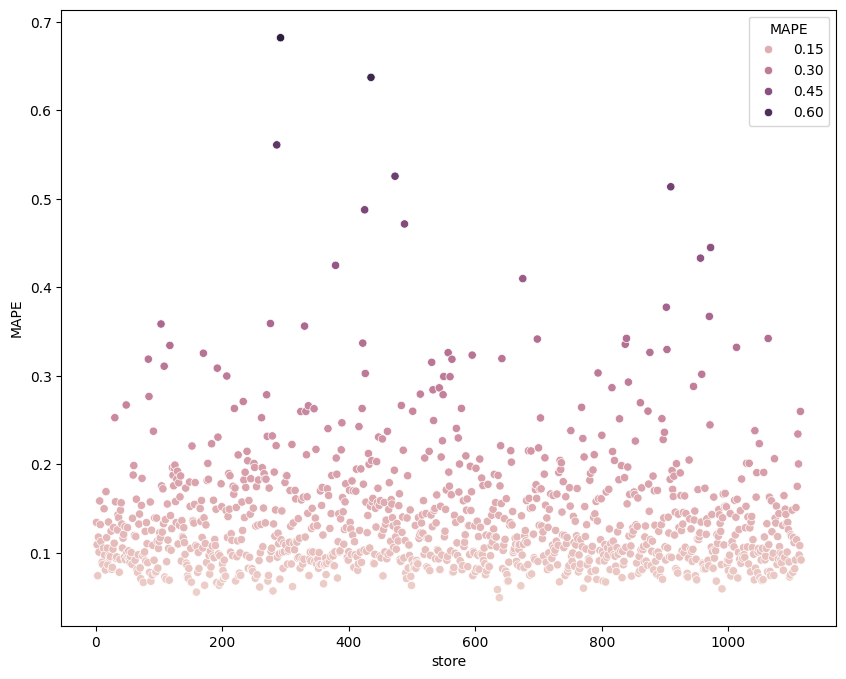

In [87]:
plt.figure(figsize=(10,8))
sns.scatterplot(x='store', y='MAPE', data=df7_aux, hue='MAPE');

**TOTAL PERFORMANCE**

In [88]:
df7_performance = df7_aux[['predictions', 'best_scenario', 'worst_scenario']].apply(lambda x: np.sum(x), axis=0).reset_index().rename(columns={'index': 'scenario', 0: 'total_sum'})
df7_performance['total_sum'] = df7_performance['total_sum'].map('R${:,.2f}'.format)
df7_performance

,scenario,total_sum
0,predictions,"R$277,443,904.00"
1,best_scenario,"R$278,512,486.62"
2,worst_scenario,"R$276,375,283.60"


**MACHINE LEARNING PERFORMANCE**

In [89]:
df7['error'] = df7['sales'] - df7['predictions']
df7['error_rate'] = df7['predictions'] / df7['sales']

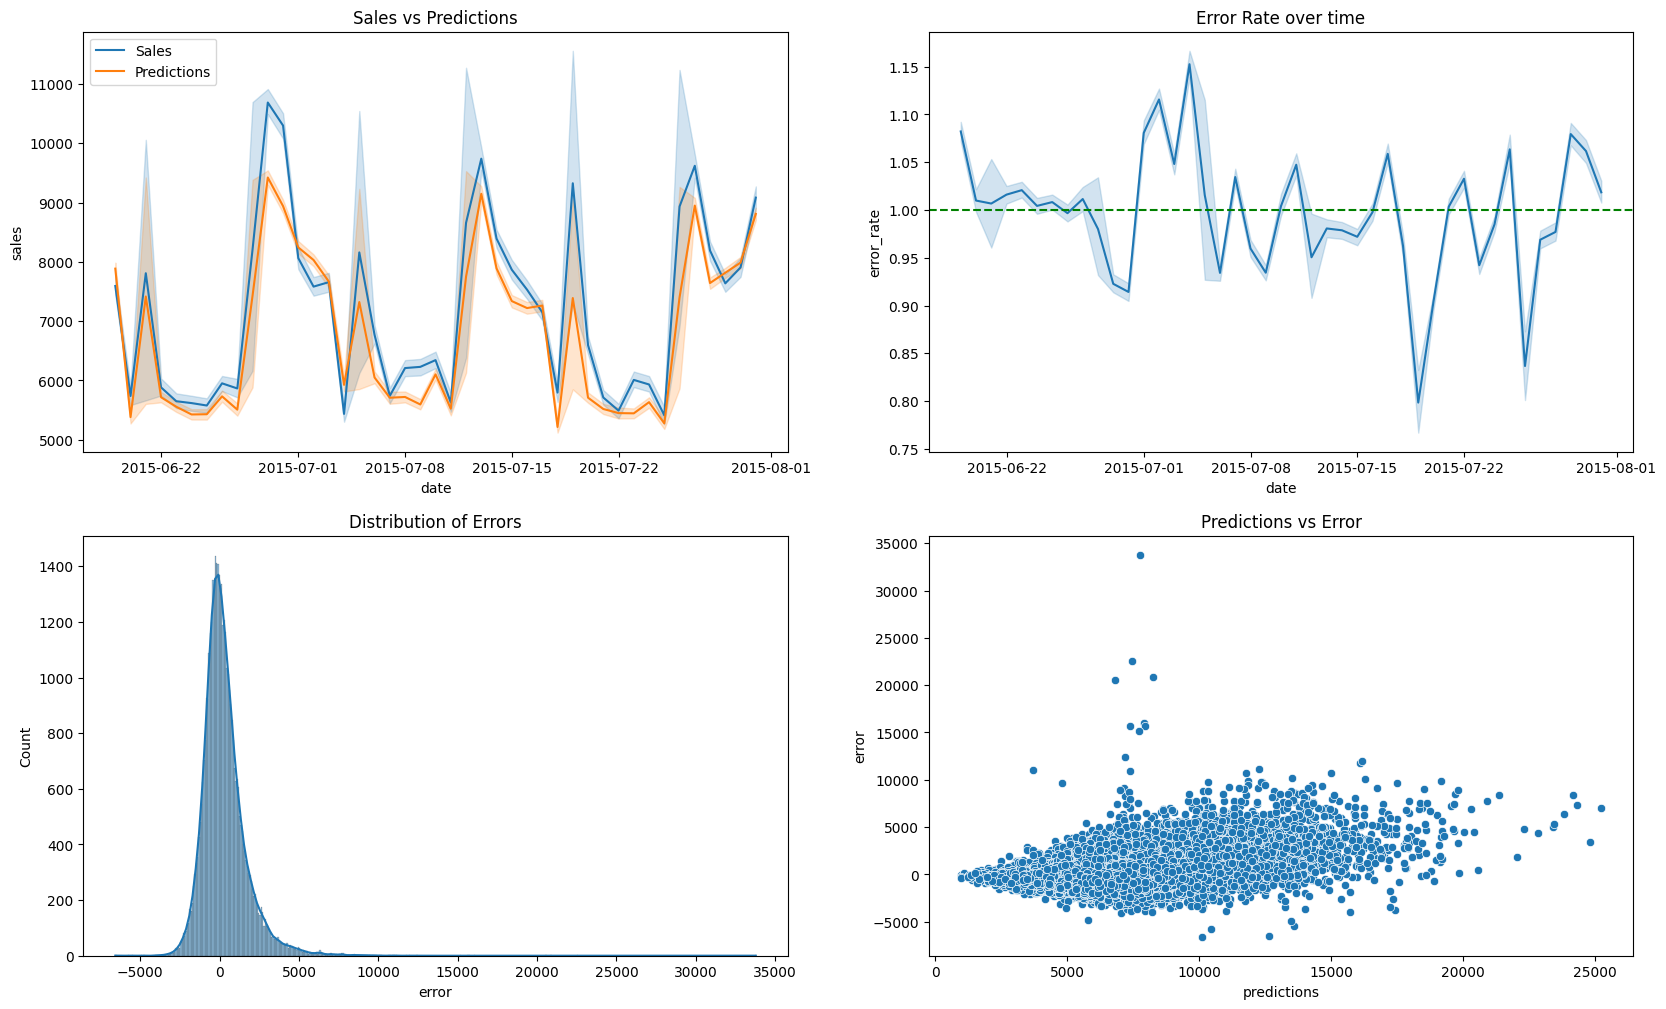

In [90]:
plt.figure(figsize=(20,12))

plt.subplot(2,2,1)
sns.lineplot(x='date', y='sales', data=df7, label='Sales')
sns.lineplot(x='date', y='predictions', data=df7, label='Predictions')
plt.title('Sales vs Predictions')

plt.subplot(2,2,2)
sns.lineplot(x='date', y='error_rate', data=df7)
plt.axhline(1, linestyle='--', color='green')
plt.title('Error Rate over time')

plt.subplot(2,2,3)
sns.histplot(df7['error'], kde=True)
plt.title('Distribution of Errors')

plt.subplot(2,2,4)
sns.scatterplot(x='predictions', y='error', data=df7)
plt.title('Predictions vs Error');

# 11. Deploy

In [98]:
# Caminho para salvar o modelo (final_model)
model_path = r"C:\Users\Marcela\Documents\projects\prediction_rossmann\model\xgb_model.pkl"

pickle.dump(random_search_model, open(model_path, 'wb'))

In [96]:
# Dicionário com os nomes das colunas e o nome do arquivo correspondente (para pickle)
scalers_info_pkl = {
    'competition_distance': 'rescaling_competition_distance.pkl',
    'competition_time_month': 'rescaling_competition_time_month.pkl',
    'promo_time_week': 'rescaling_promo_time_week.pkl'
}

# Caminho base para salvar os arquivos
base_path = r"C:\Users\Marcela\Documents\projects\prediction_rossmann\parameter"

# Loop para treinar e salvar cada scaler usando pickle
for col, filename in scalers_info_pkl.items():
    scaler = RobustScaler()
    scaler.fit(df5[[col]])
    filepath = os.path.join(base_path, filename)
    with open(filepath, 'wb') as file:
        pickle.dump(scaler, file)

# Year (assumindo que 'mms' é um MinMaxScaler ou similar)
year_scaler_path = os.path.join(base_path, 'rescaling_year.pkl')
with open(year_scaler_path, 'wb') as file:
    pickle.dump(mms, file)

# Salvar LabelEncoder
le_path = os.path.join(base_path, 'label_encoder_store_type.pkl')
with open(le_path, 'wb') as file:
    pickle.dump(le, file)

### **CLASS ROSSMANN**

In [ ]:
import math
import pickle
import datetime
import inflection
import numpy as np
import pandas as pd

class Rossmann(object):
    def __init__(self):
        self.home_path = ''
        self.rescaling_competition_distance   = pickle.load(open(self.home_path + "parameter/rescaling_competition_distance.pkl","rb"))
        self.rescaling_competition_time_month = pickle.load(open(self.home_path + "parameter/rescaling_competition_time_month.pkl","rb"))
        self.rescaling_promo_time_week        = pickle.load(open(self.home_path + "parameter/rescaling_promo_time_week.pkl","rb"))

        self.rescaling_year                   = pickle.load(open(self.home_path + "parameter/rescaling_year.pkl","rb"))

        self.label_encoder_store_type         = pickle.load(open(self.home_path + "parameter/label_encoder_store_type.pkl","rb"))
                   
    def data_cleaning(self, df1):
        # Excluir colunas Sales e Customers
        df1.drop(columns=[col for col in ['Sales', 'Customers'] if col in df1.columns], inplace=True)

        # Renomeando colunas
        df1.columns = [inflection.underscore(col) for col in df1.columns]

        # Convertendo a coluna date para datetime
        df1['date'] = pd.to_datetime(df1['date'])

        # Tratando coluna competition_distance 
        df1['competition_distance'] = df1['competition_distance'].apply(lambda x: 200000.0 if math.isnan(x) else x)

        # Tratando coluna competition_open_since_month
        df1['competition_open_since_month'] = df1.apply(lambda x: x["date"].month if math.isnan(x["competition_open_since_month"]) else x["competition_open_since_month"], axis = 1)

        # Tratando coluna competition_open_since_year
        df1['competition_open_since_year'] = df1.apply(lambda x: x["date"].year if math.isnan(x["competition_open_since_year"]) else x["competition_open_since_year"], axis = 1)

        # Tratando coluna promo2_since_week
        df1['promo2_since_week'] = df1.apply(lambda x: x["date"].week if math.isnan(x["promo2_since_week"]) else x["promo2_since_week"], axis = 1)

        # Tratando coluna promo2_since_year 
        df1['promo2_since_year'] = df1.apply(lambda x: x["date"].year if math.isnan(x["promo2_since_year"]) else x["promo2_since_year"], axis = 1)

        # Tratando coluna promo_interval
        month_map = {1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'}
        df1.fillna({'promo_interval': 0}, inplace=True)
        df1['month_map'] = df1['date'].dt.month.map(month_map)
        df1['is_promo'] = df1[['promo_interval', 'month_map']].apply(lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split(',') else 0, axis=1)

        df1['competition_open_since_month'] = df1['competition_open_since_month'].astype(int)
        df1['competition_open_since_year'] = df1['competition_open_since_year'].astype(int)
        df1['promo2_since_week'] = df1['promo2_since_week'].astype(int)
        df1['promo2_since_year'] = df1['promo2_since_year'].astype(int)

        return df1   
    
    def feature_engineering(self, df2):
        # Extraindo o ano da data
        df2['year'] = df2['date'].dt.year
        # Extraindo o mês da data
        df2['month'] = df2['date'].dt.month
        # Extraindo o dia da data
        df2['day'] = df2['date'].dt.day
        # Extraindo s semana do ano da data
        df2['week_of_year'] = df2['date'].dt.isocalendar().week
        # Year week
        df2['year_week'] = df2['date'].dt.strftime('%Y-%W')

        # Tempo em meses em que há lojas concorrentes 
        df2['competition_since'] = df2.apply(lambda x: datetime.datetime(year=x['competition_open_since_year'], month=x['competition_open_since_month'], day=1), axis=1)
        df2['competition_time_month'] = ((df2['date'] - df2['competition_since'])/30).apply(lambda x: x.days).astype(int)

        # Obter o tempo de promoção
        df2['promo_since'] = pd.to_datetime(df2['promo2_since_year'].astype(str) + df2['promo2_since_week'].astype(str) + '-1', format='%Y%W-%w') - pd.Timedelta(days=7)
        df2['promo_time_week'] = ((df2['date'] - df2['promo_since']).dt.days // 7).astype(int)

        # Renomeando as categorias das lojas a partir da variedade de produtos
        df2['assortment'] = df2['assortment'].map({'a': 'basic', 'b': 'extra', 'c': 'extended'})

        # Renomeando os feriados
        mapping = {'a': 'public_holiday', 'b': 'easter_holiday', 'c': 'christmas'}
        df2['state_holiday'] = df2['state_holiday'].map(mapping).fillna('regular_day')

        df2 = df2[df2['open']!=0]

        cols_drop = ['open', 'promo_interval', 'month_map']
        df2 = df2.drop(cols_drop, axis = 1)

        return df2
    
    def data_preparation(self, df3):
        # Rescaling
        # competition distance
        df3['competition_distance'] = self.rescaling_competition_distance.transform(df3[['competition_distance']].values)
        # competition time month   
        df3['competition_time_month'] = self.rescaling_competition_time_month.transform(df3[['competition_time_month']].values)
        # promo time week
        df3['promo_time_week'] = self.rescaling_promo_time_week.transform(df3[['promo_time_week']].values)

        # year
        df3['year'] = self.rescaling_year.transform(df3[['year']].values)

        # Store holiday - One Hot Encoding
        df3 = pd.get_dummies(df3, prefix=['state_holiday'], columns=['state_holiday'])

        # Store type - Label Encoding
        df3['store_type'] = self.label_encoder_store_type.transform(df3['store_type'])

        # Assortment - Ordinal Encoding
        assortment_dic = {'basic': 1, 'extra': 2, 'extended': 3}
        df3['assortment'] = df3['assortment'].map(assortment_dic)

        # Transformacao de natureza
        # Day of week
        df3['day_of_week_sin'] = df3['day_of_week'].apply(lambda x: np.sin(x * (2. * np.pi / 7)))
        df3['day_of_week_cos'] = df3['day_of_week'].apply(lambda x: np.cos(x * (2. * np.pi / 7)))

        # month
        df3['month_sin'] = df3['month'].apply(lambda x: np.sin(x * (2. * np.pi / 12)))
        df3['month_cos'] = df3['month'].apply(lambda x: np.cos(x * (2. * np.pi / 12)))

        # day
        df3['day_sin'] = df3['day'].apply(lambda x: np.sin(x * (2. * np.pi / 30)))
        df3['day_cos'] = df3['day'].apply(lambda x: np.cos(x * (2. * np.pi / 30)))

        # week of year
        df3['week_of_year_sin'] = df3['week_of_year'].apply(lambda x: np.sin(x * (2. * np.pi / 52)))
        df3['week_of_year_cos'] = df3['week_of_year'].apply(lambda x: np.cos(x * (2. * np.pi / 52)))

        features_selected = ['store', 'promo', 'store_type', 'assortment', 'competition_distance', 'competition_open_since_month',
                             'competition_open_since_year', 'promo2', 'promo2_since_week', 'promo2_since_year', 'competition_time_month',
                             'promo_time_week', 'day_of_week_sin', 'day_of_week_cos', 'month_sin', 'month_cos', 'day_sin', 'day_cos',
                             'week_of_year_sin', 'week_of_year_cos'
                             ]

        return df3[features_selected]
    
    def get_prediction(self, model, original_data, test_data):
        # Predict
        pred = model.predict(test_data)

        # Join pred + original data
        original_data['prediction'] = np.expm1(pred)

        return original_data.to_json(orient='records', date_format='iso')

### **API Handler**

In [ ]:
import os
import json
import pickle
import pandas as pd
from rossmann.Rossmann import Rossmann
from flask import Flask, request, Response


# Load model
model = pickle.load(open('model/xgb_model.pkl', 'rb'))

app = Flask(__name__)
@app.route('/rossmann/predict', methods=['POST'])

def rossmann_predict():
    test_json = request.get_json()

    if test_json:
        if isinstance(test_json, dict):
            test_raw = pd.DataFrame(test_json, index=[0])
        else:
            test_raw = pd.DataFrame(test_json, columns=test_json[0].keys(), )

        # Instantiate Rossmann class
        pipeline = Rossmann()

        # Data Cleaning
        df1 = pipeline.data_cleaning(test_raw)

        # Feature Engineering
        df2 = pipeline.feature_engineering(df1)

        # Data Preparation
        df3 = pipeline.data_preparation(df2)

        # Prediction
        df_response = pipeline.get_prediction(model, test_raw, df3)

        return df_response 

    else:
        return Response('{}', status=200, mimetype='application/json')
    


if __name__ == '__main__':
    # port = os.environ.get('PORT', 5000) # Usado no deploy
    app.run(host='0.0.0.0', port=port) # localhost

 * Serving Flask app '__main__'
 * Debug mode: off


 * Running on http://localhost:5000
Press CTRL+C to quit
127.0.0.1 - - [14/Apr/2025 15:27:51] "GET / HTTP/1.1" 404 -
127.0.0.1 - - [14/Apr/2025 15:27:51] "GET /favicon.ico HTTP/1.1" 404 -
127.0.0.1 - - [14/Apr/2025 15:28:22] "GET / HTTP/1.1" 404 -
127.0.0.1 - - [14/Apr/2025 15:30:50] "GET / HTTP/1.1" 404 -


### **API Tester**

In [99]:
df_test_raw = pd.read_csv(r'C:\Users\Marcela\Documents\projects\prediction_rossmann\data\test.csv')


df_test = pd.merge(df_test_raw, df_store_raw, how='left', on='Store')

Vamos testar para uma única loja se a API está funcionando, antes de aplicar a todo o dataset.

In [100]:
#df_test = df_test[df_test['Store'] == 22]

# Remover dias fechados
df_test = df_test[df_test['Open'] != 0]
df_test = df_test[~df_test['Open'].isnull()]

# Excluir Id
df_test = df_test.drop('Id', axis=1)


In [101]:
# Converter DataFrame para JSON
data = json.dumps(df_test.to_dict(orient='records'))

In [102]:
# API Call
#url = 'http://127.0.0.1:5000/rossmann/predict' 
url = 'https://api-rossmann-prediction.onrender.com/rossmann/predict' # Deploy do modelo
header = {'Content-Type': 'application/json'}

response = requests.post(url, data=data, headers=header)
print('Status code {}'.format(response.status_code))

Status code 200


In [103]:
d1 = pd.DataFrame(response.json(), columns=response.json()[0].keys())

In [104]:
d1.head()

,store,day_of_week,date,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,...,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week,prediction
0,1,4,2015-09-17T00:00:00.000,1.0,1,regular_day,0,c,basic,1270.0,...,2015,9,17,38,2015-37,2008-09-01T00:00:00.000,85,2015-09-14T00:00:00.000,0,6213.965820
1,3,4,2015-09-17T00:00:00.000,1.0,1,regular_day,0,a,basic,14130.0,...,2015,9,17,38,2015-37,2006-12-01T00:00:00.000,107,2011-03-28T00:00:00.000,233,5969.869141
2,7,4,2015-09-17T00:00:00.000,1.0,1,regular_day,0,a,extended,24000.0,...,2015,9,17,38,2015-37,2013-04-01T00:00:00.000,29,2015-09-14T00:00:00.000,0,6723.602539
3,8,4,2015-09-17T00:00:00.000,1.0,1,regular_day,0,a,basic,7520.0,...,2015,9,17,38,2015-37,2014-10-01T00:00:00.000,11,2015-09-14T00:00:00.000,0,6185.987793
4,9,4,2015-09-17T00:00:00.000,1.0,1,regular_day,0,a,extended,2030.0,...,2015,9,17,38,2015-37,2000-08-01T00:00:00.000,184,2015-09-14T00:00:00.000,0,6933.438965


In [105]:
d2 = d1[['store', 'prediction']].groupby('store').sum().reset_index()

for i in range(len(d2)):
    print('A loja {} irá vender R${:,.2f} nas próximas 6 semanas'.format(d2['store'][i], d2['prediction'][i]))

A loja 1 irá vender R$237,223.43 nas próximas 6 semanas
A loja 3 irá vender R$220,447.24 nas próximas 6 semanas
A loja 7 irá vender R$249,906.31 nas próximas 6 semanas
A loja 8 irá vender R$234,594.79 nas próximas 6 semanas
A loja 9 irá vender R$255,524.52 nas próximas 6 semanas
A loja 10 irá vender R$236,995.51 nas próximas 6 semanas
A loja 11 irá vender R$242,207.29 nas próximas 6 semanas
A loja 12 irá vender R$276,251.35 nas próximas 6 semanas
A loja 13 irá vender R$248,627.91 nas próximas 6 semanas
A loja 14 irá vender R$233,384.55 nas próximas 6 semanas
A loja 15 irá vender R$268,518.89 nas próximas 6 semanas
A loja 16 irá vender R$245,302.16 nas próximas 6 semanas
A loja 19 irá vender R$262,049.71 nas próximas 6 semanas
A loja 20 irá vender R$243,580.09 nas próximas 6 semanas
A loja 21 irá vender R$287,073.53 nas próximas 6 semanas
A loja 22 irá vender R$225,244.89 nas próximas 6 semanas
A loja 23 irá vender R$235,417.09 nas próximas 6 semanas
A loja 24 irá vender R$279,685.04 na